# Assignment 1

# Authors: 
- Enzo Benoit-Jeannin 
- Sasha Denouvilliez-Pech 

Author:
* Ali Karami: ali.karami@mcgill.ca


In [20]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
import math

plt.rcParams["figure.figsize"]=10,5

## Q1 Simulator for Bernoulli Bandit

In [21]:
class BernoulliBandit:
  """
  A class for Bernoulli multi-armed bandit.

  Attributes
  ----------
  num_arms : int
      The number of arms in the bernoulli bandit
  probs_arr : array of integer (size num_arms)
      The binomial distribution parameter p_k (probability of drawing 1) of each arm indexed from 0

  Methods
  -------
  sample(arm_index)
      Returns a reward sample of the binomial distribution indexed by the arm_index (return 0 with probability
      1-probs_arr[k] and 1 with probability probs_arr[k])
  """

  def __init__(self, num_arms, probs_arr):
    self.num_arms = num_arms
    self.probs_arr = probs_arr

  def sample(self, arm_index):
    # Simulates a Bernoulli trial for the arm at the specified index.
    # np.random.binomial(1, p) is equivalent to a Bernoulli distribution with probability p.
    return np.random.binomial(1, self.probs_arr[arm_index])

In [22]:
delta = 0.1
num_arms = 3
probs_arr = [0.5+delta, 0.5, 0.5-delta]
num_samples = 50

three_arm_bernoulli_bandit = BernoulliBandit(num_arms, probs_arr)
actions = range(num_arms)

action_rewards = []
for action in actions:
  # store 50 samples per action
  rewards = [three_arm_bernoulli_bandit.sample(action) for _ in range(num_samples)]
  action_rewards.append(rewards)

# print("action_rewards: ", action_rewards)

### Graphs

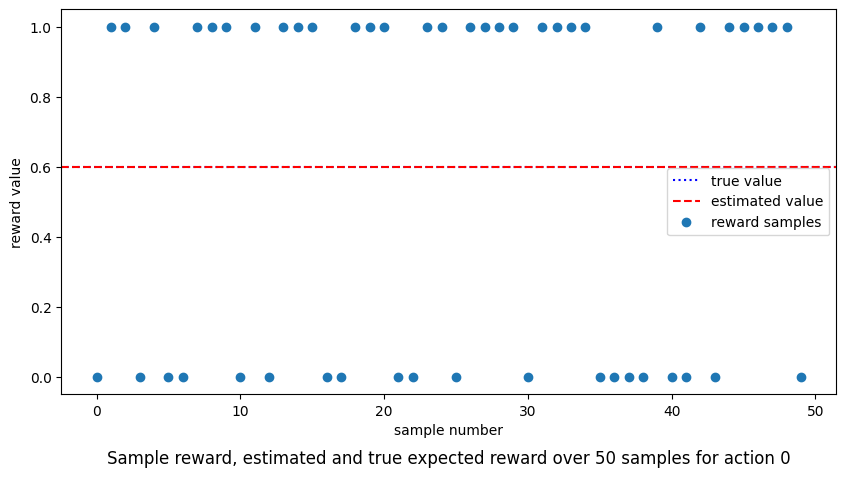

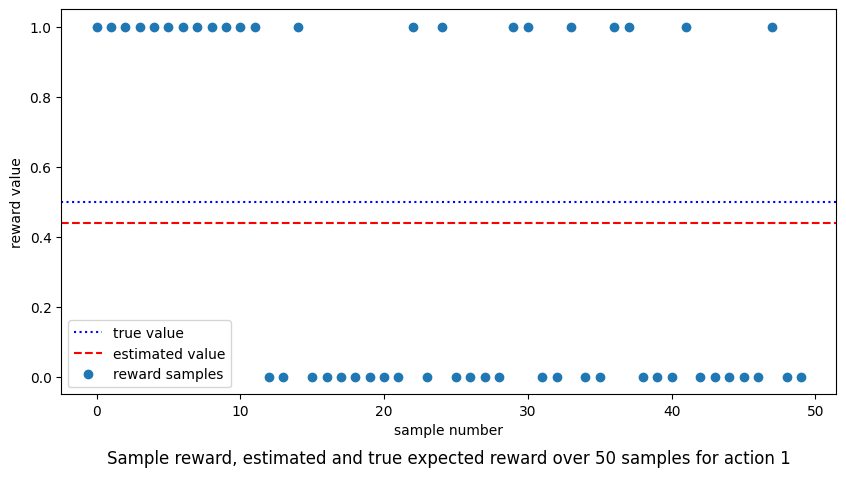

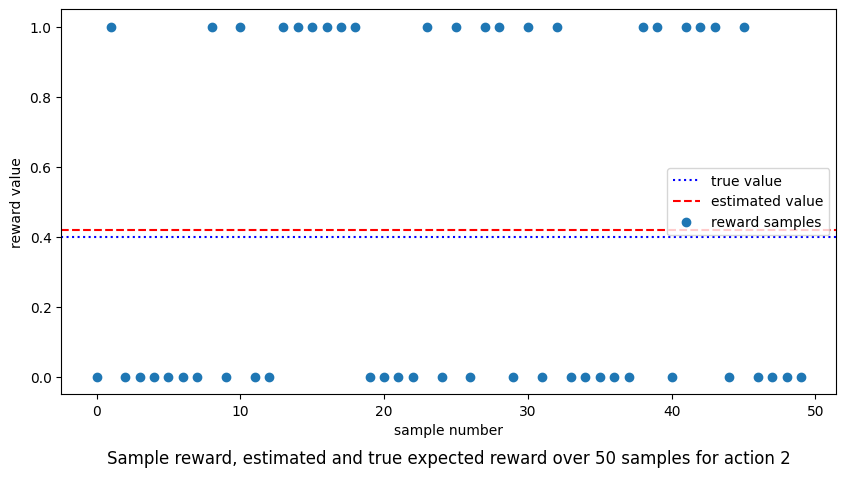

In [4]:
for action in actions:
  fig, ax = plt.subplots()

  true_value = probs_arr[action]
  estimated_value = np.mean(action_rewards[action])
  
  # To validate incremental and regular are the same
  # print("estimated mean: ", estimated_value)
  
  # draw the line of the true value
  line_true_val = ax.axhline(y = true_value, color = 'b', linestyle = ':', label = "true value")
  # draw the line of the estimated value
  line_est_val = ax.axhline(y = estimated_value, color = 'r', linestyle = '--', label = "estimated value")
  # plot the reward samples
  plt_samples, = ax.plot(action_rewards[action], 'o', label = "reward samples")

  ax.set_xlabel("sample number")
  ax.set_ylabel("reward value")
  ax.set_title("Sample reward, estimated and true expected reward over 50 samples for action %s" %action, y=-0.2)

  # show the legend with the labels of the line
  ax.legend(handles=[line_true_val, line_est_val, plt_samples])

### Q1 - Results Analysis:



The estimated value lines seem to converge reasonably well towards the true probability values, indicating that the empirical means are good representations of the true probabilities.
The spread of the sample dots at 0 and 1 levels reflects the stochastic nature of the Bernoulli process. Some arms show a more balanced spread (closer to their corresponding true value), while others might exhibit a slight deviation, which is expected due to randomness.

## Q2 Estimated Q values

In [5]:
def update(reward_samples, alpha):
  """
  Each call to the function yields the current incremental average of the reward with a fixed learning rate, alpha
  E.g. Inital call returns alpha * reward_samples[0], second call returns prev_val + alpha * (reward_samples[1] - prev_val)
  where prev_val is the value return from the previous call, so on and so forth

  Parameters
  ----------
  reward_samples : array of int
      samples of reward values from one arm of a bandit
  alpha : int
      learning rate parameter for the averaging
  """
  prev_val = 0
  for sample in reward_samples:
    new_val = prev_val + alpha * (sample - prev_val)
    prev_val = new_val
    yield new_val

def updateAvg(reward_samples):
  """
  Each call to the function yields the current incremental average of the reward
  E.g. Inital call returns reward_samples[0], second call returns the average of reward_samples[0] and reward_samples[0], so on and so forth

  Parameters
  ----------
  reward_samples : array of int
      samples of reward values from one arm of a bandit
  """
  prev_val = reward_samples[0]
  n = 1
  # first iteration only updates n to 2, no update to average
  for sample in reward_samples:
    new_val = prev_val + (sample - prev_val) / n
    prev_val = new_val
    n += 1
    yield new_val

### Graphs

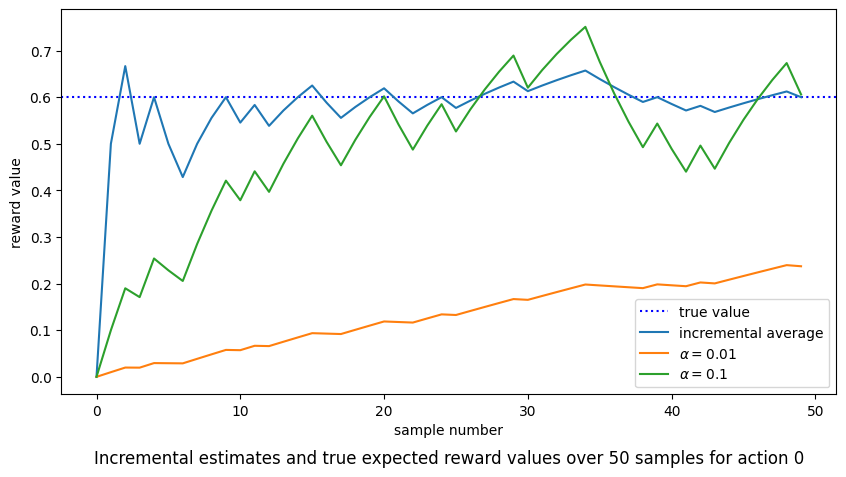

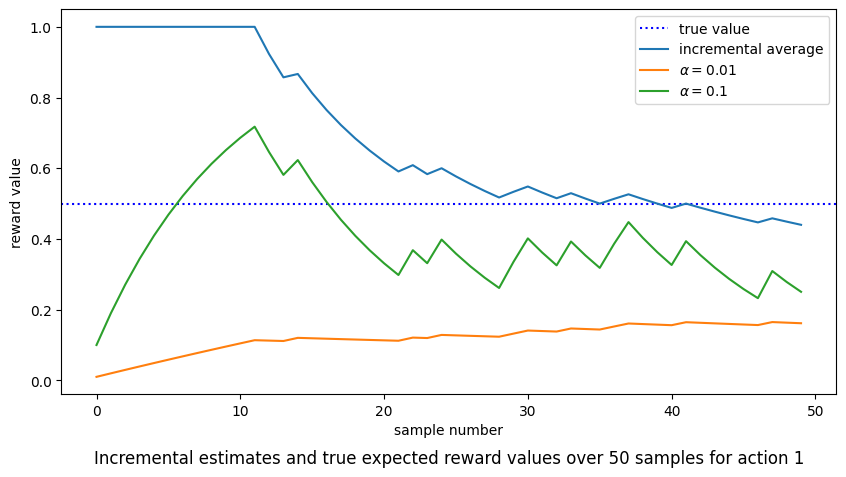

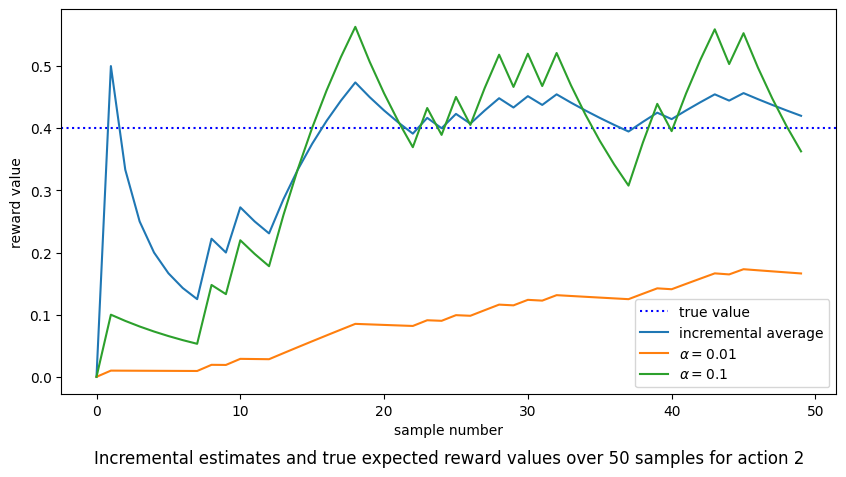

In [6]:
for action in actions:
  fig, ax = plt.subplots()

  # obtain incremental values for averaging, alpha = 0.01, alpha = 0.1
  incr_avgs = list(updateAvg(action_rewards[action]))
  alpha_1_percent = list(update(action_rewards[action], 0.01))
  alpha_10_percent = list(update(action_rewards[action], 0.1))
  
  # # To validate incremental and regular are the same
  # print("incr_avgs: ", incr_avgs[49])

  true_value = probs_arr[action]

  # draw the true value line
  line_true_val = ax.axhline(y = true_value, color = 'b', linestyle = ':', label = "true value")

  # plot incremental values for averaging, alpha = 0.01, alpha = 0.1
  plt_incr_avgs, = ax.plot(incr_avgs, label = "incremental average")
  plt_alpha_1_percent, = ax.plot(alpha_1_percent, label = r"$\alpha = 0.01$")
  plt_alpha_10_percent, = ax.plot(alpha_10_percent, label = r"$\alpha = 0.1$")

  ax.set_xlabel("sample number")
  ax.set_ylabel("reward value")
  ax.set_title("Incremental estimates and true expected reward values over 50 samples for action %s" %action, y=-0.2)

  # show the legend with the labels of the line
  ax.legend(handles=[line_true_val, plt_incr_avgs, plt_alpha_1_percent, plt_alpha_10_percent])

### Q2 - Results Analysis:



For all actions, the orange line, representing a lower learning rate ($ \alpha = 0.01 $), shows the least fluctuation, indicating stability in the estimation process. However, it doesn't approach the true value within the 50-sample window, suggesting a trade-off where lower $ \alpha $ values may require more samples to converge accurately.

Conversely, both the incremental average and the $ \alpha = 0.1 $ lines closely track the true value, with the latter showing a higher volatility. This raises a key point about the convergence rate: a higher $ \alpha $ could accelerate the adjustment of estimates, beneficial for rapid learning but at the cost of potential overreaction to individual samples.

Additionally, initial estimates, which can be important in environments where early accuracy is crucial, differ based on the learning rate. The more aggressive $ \alpha = 0.1 $ quickly adjusts away from the initial guess, while the incremental average shows a gradual but steady improvement. This emphasizes the importance of selecting an appropriate $ \alpha $ to balance between early learning and long-term convergence stability.

To better generalize the results and drive more stable conclusions, the experiments are repeated 100 times and averaged. See the next section for the results.

## Q3 Effect of $α$ on Estimated Q values

In [7]:
num_samples = 100

# arrays of the data generated from 100 runs
incr_avgs_runs = []
alpha_1_percent_runs = []
alpha_10_percent_runs = []

for run in range(100):
  # arrays of data generated from the 3 actions in 1 run
  sample_incr_avgs_by_actions = []
  sample_alpha_1_percent_by_actions = []
  sample_alpha_10_percent_by_actions = []

  for action in actions:
    rewards = [three_arm_bernoulli_bandit.sample(action) for _ in range(num_samples)]

    sample_incr_avgs_by_actions.append(list(updateAvg(rewards)))
    sample_alpha_1_percent_by_actions.append(list(update(rewards, 0.01)))
    sample_alpha_10_percent_by_actions.append(list(update(rewards, 0.1)))

  incr_avgs_runs.append(sample_incr_avgs_by_actions)
  alpha_1_percent_runs.append(sample_alpha_1_percent_by_actions)
  alpha_10_percent_runs.append(sample_alpha_10_percent_by_actions)

# convert to np arrays
incr_avgs_runs = np.asarray(incr_avgs_runs)
alpha_1_percent_runs = np.asarray(alpha_1_percent_runs)
alpha_10_percent_runs = np.asarray(alpha_10_percent_runs)

### Graphs

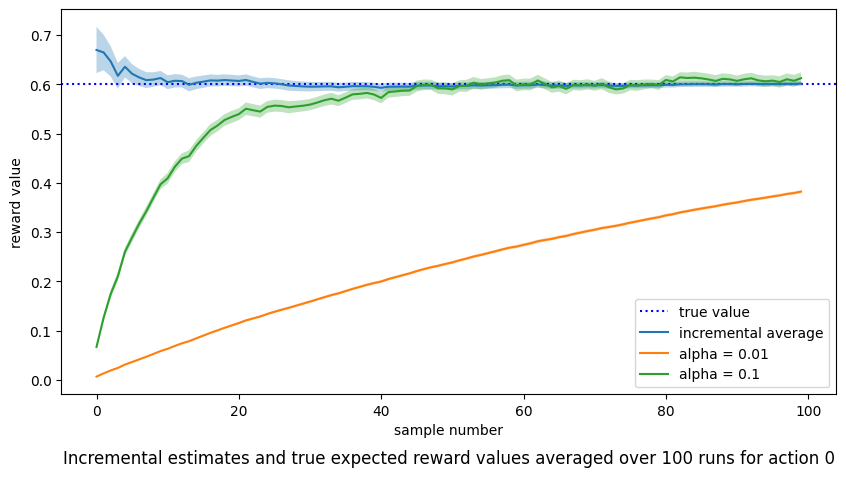

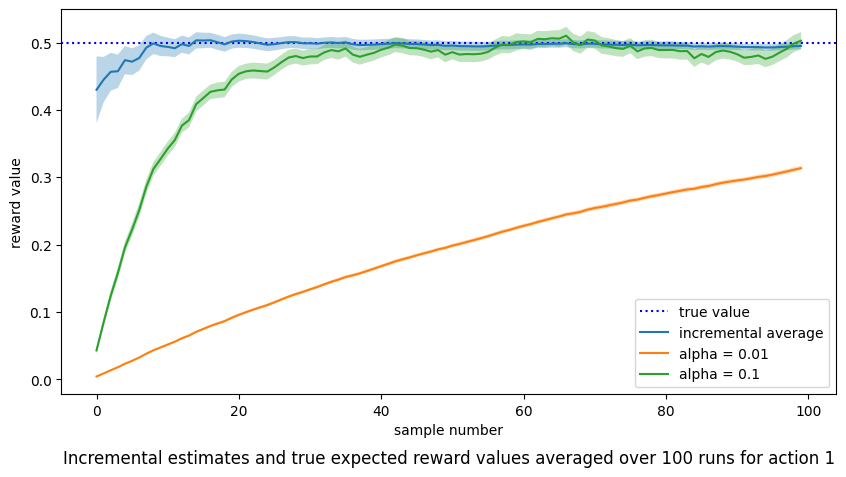

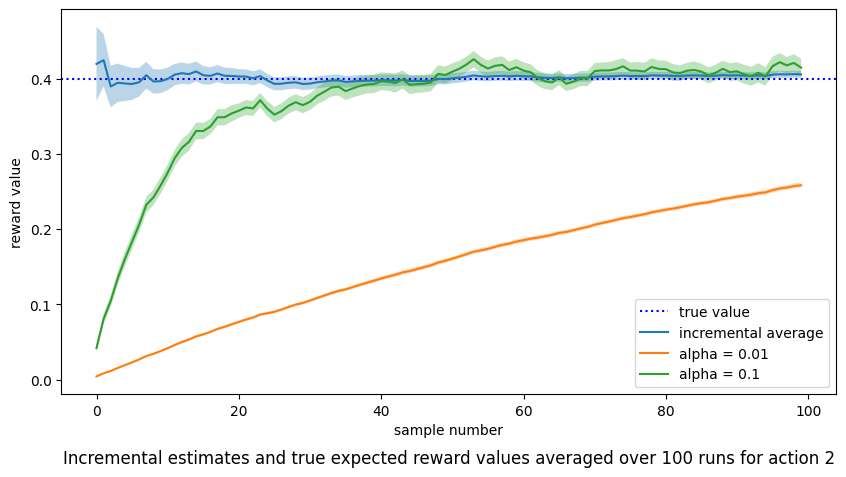

In [8]:
for action in actions:
  fig, ax = plt.subplots()

  # obtain averaged incremental reward values for averaging, alpha = 0.01, alpha = 0.1 over 100 runs
  mean_incr_avgs_by_actions = np.mean(incr_avgs_runs[:,action,:], axis=0)
  mean_alpha_1_percent_by_actions = np.mean(alpha_1_percent_runs[:,action,:], axis=0)
  mean_alpha_10_percent_by_actions = np.mean(alpha_10_percent_runs[:,action,:], axis=0)
  true_value = probs_arr[action]

  # obtain the standard deviation for averaging, alpha = 0.01, alpha = 0.1 over 100 runs
  std_incr_avgs_by_actions = np.std(incr_avgs_runs[:,action,:], axis=0)
  std_alpha_1_percent_by_actions = np.std(alpha_1_percent_runs[:,action,:], axis=0)
  std_alpha_10_percent_by_actions = np.std(alpha_10_percent_runs[:,action,:], axis=0)

  # obtain the standard error for averaging, alpha = 0.01, alpha = 0.1 over 100 runs
  std_err_incr_avgs_by_actions = np.std(incr_avgs_runs[:,action,:], axis=0) / np.sqrt(np.size(incr_avgs_runs[:,action,:], axis=0))
  std_err_alpha_1_percent_by_actions = np.std(alpha_1_percent_runs[:,action,:], axis=0) / np.sqrt(np.size(alpha_1_percent_runs[:,action,:], axis=0))
  std_err_alpha_10_percent_by_actions = np.std(alpha_10_percent_runs[:,action,:], axis=0) / np.sqrt(np.size(alpha_10_percent_runs[:,action,:], axis=0))

  # draw the true value line
  line_true_val = ax.axhline(y = true_value, color = 'b', linestyle = ':', label = "true value")

  # draw the averaged incremental reward values for averaging
  plt_incr_avgs, = ax.plot(mean_incr_avgs_by_actions, label = "incremental average")
  # draw the error bar/area for averaging
  incr_avgs_minus_std_err = mean_incr_avgs_by_actions - std_err_incr_avgs_by_actions
  incr_avgs_plus_std_err = mean_incr_avgs_by_actions + std_err_incr_avgs_by_actions
  ax.fill_between(range(0,100), incr_avgs_minus_std_err, incr_avgs_plus_std_err, alpha=0.3)

  # draw the averaged incremental reward values for alpha = 0.01
  plt_alpha_1_percent, = ax.plot(mean_alpha_1_percent_by_actions, label = "alpha = 0.01")
  # draw the error bar/area for alpha = 0.01
  alpha_1_percent_minus_std_err = mean_alpha_1_percent_by_actions - std_err_alpha_1_percent_by_actions
  alpha_1_percent_plus_std_err = mean_alpha_1_percent_by_actions + std_err_alpha_1_percent_by_actions
  ax.fill_between(range(0,100), alpha_1_percent_minus_std_err, alpha_1_percent_plus_std_err, alpha=0.3)

  # draw the averaged incremental reward values for alpha = 0.1
  plt_alpha_10_percent, = ax.plot(mean_alpha_10_percent_by_actions, label = "alpha = 0.1")
  # draw the error bar/area for alpha = 0.1
  alpha_10_percent_minus_std_err = mean_alpha_10_percent_by_actions - std_err_alpha_10_percent_by_actions
  alpha_10_percent_plus_std_err = mean_alpha_10_percent_by_actions + std_err_alpha_10_percent_by_actions
  ax.fill_between(range(0,100), alpha_10_percent_minus_std_err, alpha_10_percent_plus_std_err, alpha=0.3)

  ax.set_xlabel("sample number")
  ax.set_ylabel("reward value")
  ax.set_title("Incremental estimates and true expected reward values averaged over 100 runs for action %s" %action, y=-0.2)

  ax.legend(handles=[line_true_val, plt_incr_avgs, plt_alpha_1_percent, plt_alpha_10_percent])

### Q3 - Results Analysis:


Observing the graphs for all actions averaged over 100 runs, the $ \alpha = 0.1 $ line shows rapid convergence towards the true value but with notable variability, indicating a higher value for the learning rate may overshoot before stabilizing. The incremental average curve is less volatile, hovers closer to the true value and provides accurate initial estimates, suggesting it provides a more reliable estimate over time. The $ \alpha = 0.01 $ line is the most stable but converges slowly, potentially requiring more than 100 samples to reach the true value. To optimize further, considering the performance of $ \alpha = 0.1 $, exploring a range of $ \alpha $ values higher than 0.1 might yield an even faster convergence rate although it may come at the cost of higher volatility.

## Q4 Epsilon-greedy

In [27]:
def epsilon_greedy(bandit, epsilon, alpha = None, num_time_step = 1000, non_stationary = False):
  """Epsilon greedy algorithm for bandit action selection

  Parameters
  ----------
  bandit : bandit class
      A bernoulli bandit attributes num_arms and probs_arr, and method sample
  epsilon: float
      A parameter which determines the probability for a random action to be selected
  alpha: (optional) float
      A parameter which determined the learning rate for averaging. If alpha is none, incremental averaging is used.
      Default is none, corresponding to incremental averaging.
    non_stationary: (optional) boolean
        A parameter which determines whether the bandit is non-stationary. If true, the bandit is non-stationary.
  Returns
  -------
  R_over_t
      a list of instantaneous return over the time steps
  total_R_over_t
      a list of cummulative reward over the time steps
  est_is_best_over_t
      a list of values of 0 and 1 where 1 indicates the estimated best action is the true best action and 0 otherwise for each time step
  l_over_t
      a list of instanteneous regret over the time steps
  total_l_over_t
      a list of cummulative regret over the time steps
  """

  num_arms = bandit.num_arms

  Q_arr = np.zeros(num_arms) # array of estimated average reward for each action
  N_arr = np.zeros(num_arms) # array of number of times picked for each action
  total_R = 0
  total_l = 0
  actions = range(num_arms)

  opt_value = max(bandit.probs_arr) # highest expected reward among all actions
  best_action = np.argmax(bandit.probs_arr) # the index of the action with highest expected reward

  R_over_t = []
  total_R_over_t = []
  est_is_best_over_t = []
  l_over_t = []
  total_l_over_t = []

  for time_step in range(num_time_step):
    # If in non-stationnary, after 500 time steps, the parameter of actions 2 and 3 become 0:5 + delta * 2  and 0:5 + delta * 3 respectively
    if non_stationary and time_step == 500:
        bandit.probs_arr[1] = 0.5 + delta * 2
        bandit.probs_arr[2] = 0.5 + delta * 3
        
    max_Q = max(Q_arr)
    A_star = np.random.choice([i for i, q in enumerate(Q_arr) if q == max_Q]) # get action with highest estimated average reward with random tie-breaking
    A_random = np.random.choice(actions) # pick a random action
    A = np.random.choice([A_star, A_random], p=[1 - epsilon, epsilon]) # pick a random action with probability epsilon
    curr_R = bandit.sample(A)
    N_arr[A] = N_arr[A] + 1

    if alpha == None:
      # incremental averaging
      Q_arr[A] = Q_arr[A] + (1 / N_arr[A]) * (curr_R - Q_arr[A])
    else:
      Q_arr[A] = Q_arr[A] + alpha * (curr_R - Q_arr[A])

    R_over_t.append(curr_R)

    total_R = total_R + curr_R
    total_R_over_t.append(total_R)

    # est_is_best is 1 if the estimated best action is the true best action
    est_is_best = 1 if A == best_action else 0
    est_is_best_over_t.append(est_is_best)

    # Calculate instantaneous regret as the difference between optimal and expected reward of the action taken
    l_t = opt_value - bandit.probs_arr[A] 
    l_over_t.append(l_t)

    total_l = total_l + l_t
    total_l_over_t.append(total_l)

  return R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t

### Graphs

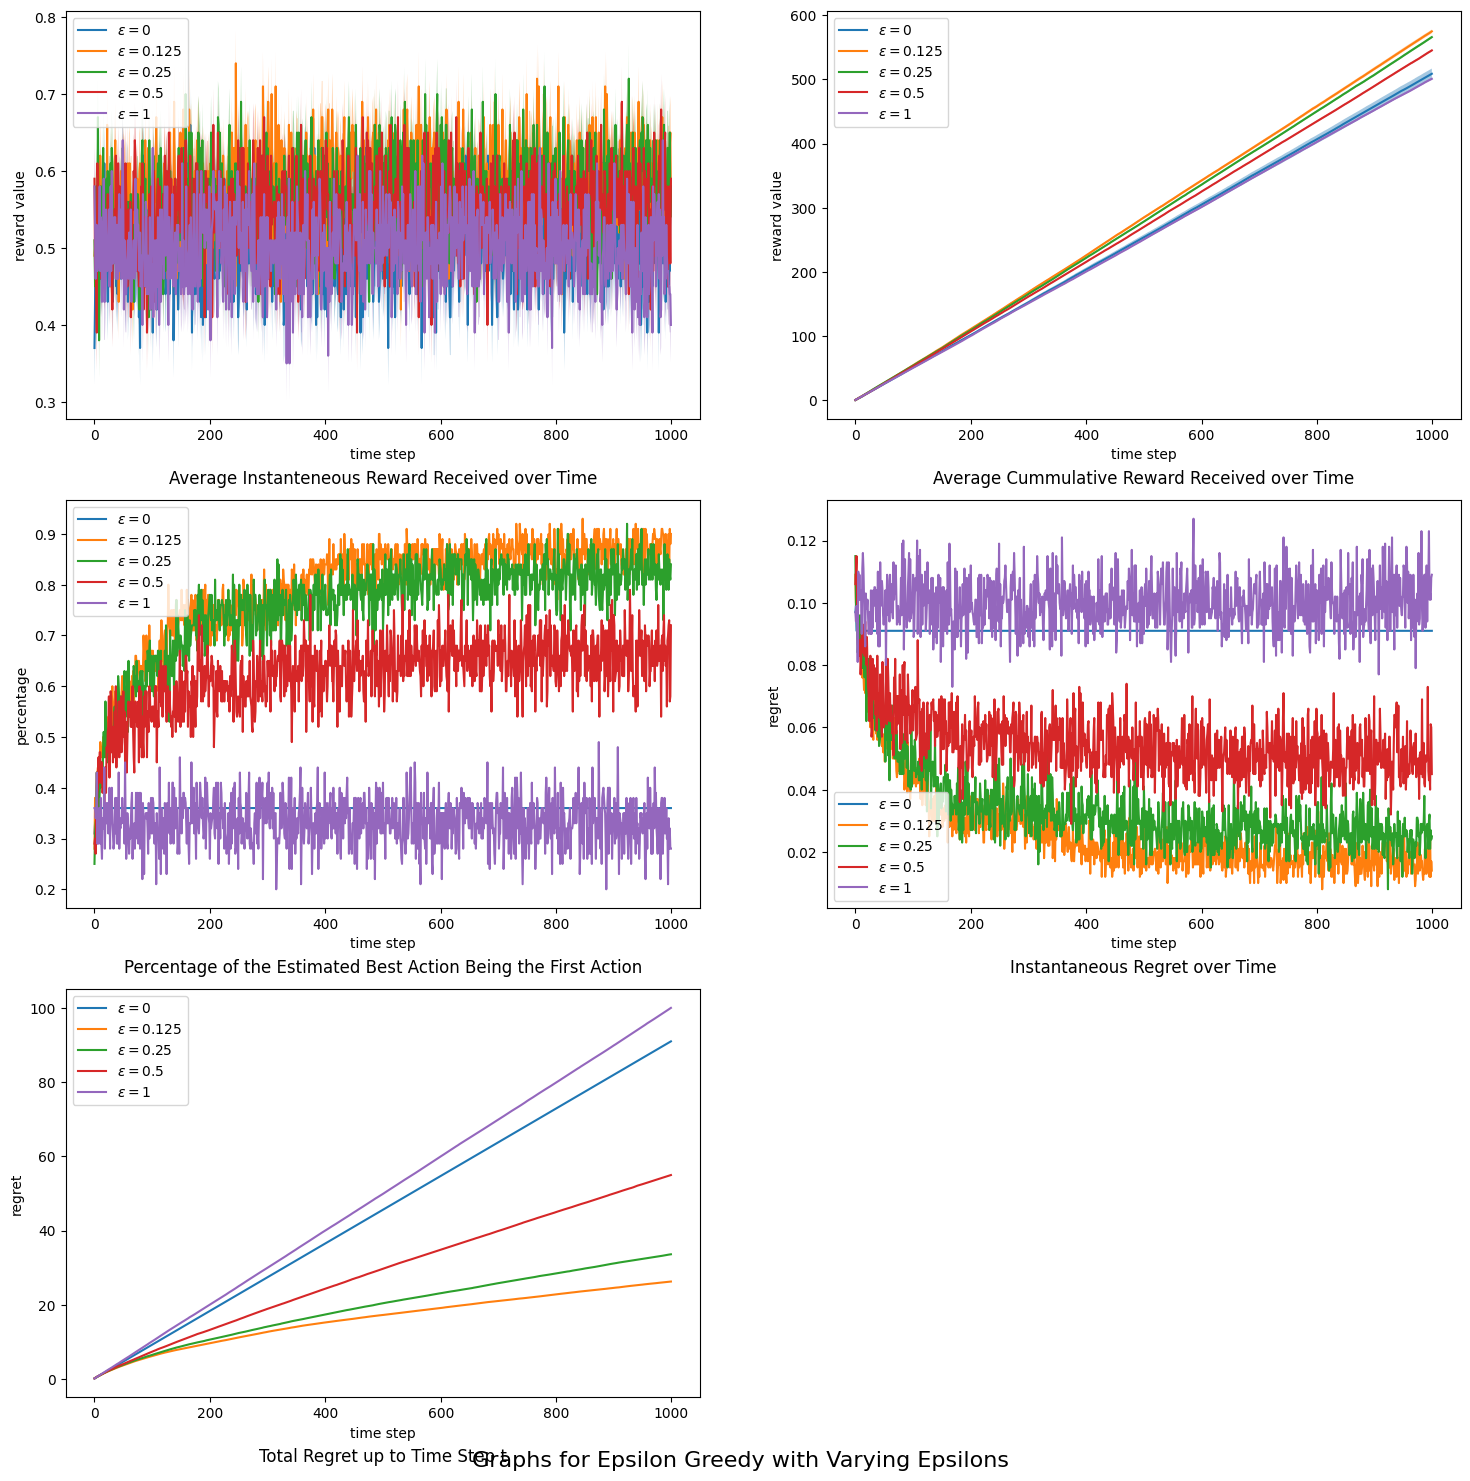

In [10]:
epsilons = [0, 1/8, 1/4, 1/2, 1]

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(18, 18))

for epsilon in epsilons:

  # arrays of the data generated from 100 runs
  R_over_t_runs = []
  total_R_over_t_runs = []
  est_is_best_over_t_runs = []
  l_over_t_runs = []
  total_l_over_t_runs = []

  for run in range(100):
    R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t = epsilon_greedy(three_arm_bernoulli_bandit, epsilon)

    R_over_t_runs.append(R_over_t)
    total_R_over_t_runs.append(total_R_over_t)
    est_is_best_over_t_runs.append(est_is_best_over_t)
    l_over_t_runs.append(l_over_t)
    total_l_over_t_runs.append(total_l_over_t)

  R_over_t_runs = np.asarray(R_over_t_runs)
  total_R_over_t_runs = np.asarray(total_R_over_t_runs)
  est_is_best_over_t_runs = np.asarray(est_is_best_over_t_runs)
  l_over_t_runs = np.asarray(l_over_t_runs)
  total_l_over_t_runs = np.asarray(total_l_over_t_runs)

  # plot the mean reward over time

  mean_R_over_t_runs = np.mean(R_over_t_runs, axis=0)
  std_err_R_over_t_runs = np.std(R_over_t_runs, axis=0) / np.sqrt(np.size(R_over_t_runs, axis=0))

  axs[0,0].plot(mean_R_over_t_runs, label = r"$\epsilon = %s$" %epsilon)

  R_over_t_minus_std_err = mean_R_over_t_runs - std_err_R_over_t_runs
  R_over_t_plus_std_err = mean_R_over_t_runs  + std_err_R_over_t_runs
  axs[0,0].fill_between(range(0,1000), R_over_t_minus_std_err, R_over_t_plus_std_err, alpha=0.4)
  # axs[0,0].errorbar(range(0,1000), mean_R_over_t_runs, yerr=std_err_R_over_t_runs)

  axs[0,0].legend()
  axs[0,0].set_xlabel("time step")
  axs[0,0].set_ylabel("reward value")
  axs[0,0].set_title("Average Instanteneous Reward Received over Time", y=-0.18)

  # plot the mean cummulative reward over time

  mean_total_R_over_t_runs = np.mean(total_R_over_t_runs, axis=0)
  std_err_total_R_over_t_runs = np.std(total_R_over_t_runs, axis=0) / np.sqrt(np.size(total_R_over_t_runs, axis=0))

  axs[0,1].plot(mean_total_R_over_t_runs, label = r"$\epsilon = %s$" %epsilon)

  total_R_over_t_minus_std_err = mean_total_R_over_t_runs - std_err_total_R_over_t_runs
  total_R_over_t_plus_std_err = mean_total_R_over_t_runs  + std_err_total_R_over_t_runs
  axs[0,1].fill_between(range(0,1000), total_R_over_t_minus_std_err, total_R_over_t_plus_std_err, alpha=0.4)

  axs[0,1].legend()
  axs[0,1].set_xlabel("time step")
  axs[0,1].set_ylabel("reward value")
  axs[0,1].set_title("Average Cummulative Reward Received over Time", y=-0.18)

  #plot the mean percentage of the estimated best action being the first action

  est_is_best_over_t_runs_avgs = np.mean(est_is_best_over_t_runs, axis=0)
  plt_est_is_best_over_t_runs_avgs, = axs[1,0].plot(est_is_best_over_t_runs_avgs, label = r"$\epsilon = %s$" %epsilon)

  axs[1,0].legend()
  axs[1,0].set_xlabel("time step")
  axs[1,0].set_ylabel("percentage")
  axs[1,0].set_title("Percentage of the Estimated Best Action Being the First Action", y=-0.18)

  #plot the mean instantaneous regret over time

  l_over_t_runs_avgs = np.mean(l_over_t_runs, axis=0)
  axs[1,1].plot(l_over_t_runs_avgs, label = r"$\epsilon = %s$" %epsilon)

  axs[1,1].legend()
  axs[1,1].set_xlabel("time step")
  axs[1,1].set_ylabel("regret")
  axs[1,1].set_title("Instantaneous Regret over Time", y=-0.18)

  #plot the total regret over time

  total_l_over_t_runs_avgs = np.mean(total_l_over_t_runs, axis=0)
  axs[2,0].plot(total_l_over_t_runs_avgs, label = r"$\epsilon = %s$" %epsilon)

  axs[2,0].legend()
  axs[2,0].set_xlabel("time step")
  axs[2,0].set_ylabel("regret")
  axs[2,0].set_title("Total Regret up to Time Step t", y=-0.18)

axs[-1, -1].axis('off')

title = r'Graphs for Epsilon Greedy with Varying Epsilons'
fig.suptitle(title, fontsize=16, y=0.08)

plt.show()

### Q4 - Results Analysis:

The orange line, representing epsilon at 0.125, demonstrates superior performance with the highest average reward (both instantaneous and cumulative) and the lowest cumulative and instantaneous regret over time, suggesting an effective balance between exploring new choices and exploiting known profitable actions. Epsilon values of 0.25 and 0.5, while similar to each other, show less optimal outcomes, with 0.5 in particular leading to higher regret and lower reward rates, indicating too frequent exploration that detracts from leveraging the better-understood, more rewarding actions. The performance in identifying the best action as the first choice is notably high for epsilon=0.25, which is almost as effective as the leading epsilon=0.125. Howoever, an epsilon of 1, depicting a strategy of pure exploration, results in the least favorable performance, which shows that moderate exploration with more exploitation (as in epsilon 0.125) tends to perform better in these settings.

## Q5 Hyperparameters for Epsilon-greedy

To have a plain start, you have been provided with predefined functions for generating plots until now. However, moving forward, you are expected to plot graphs on your own.

### Graphs

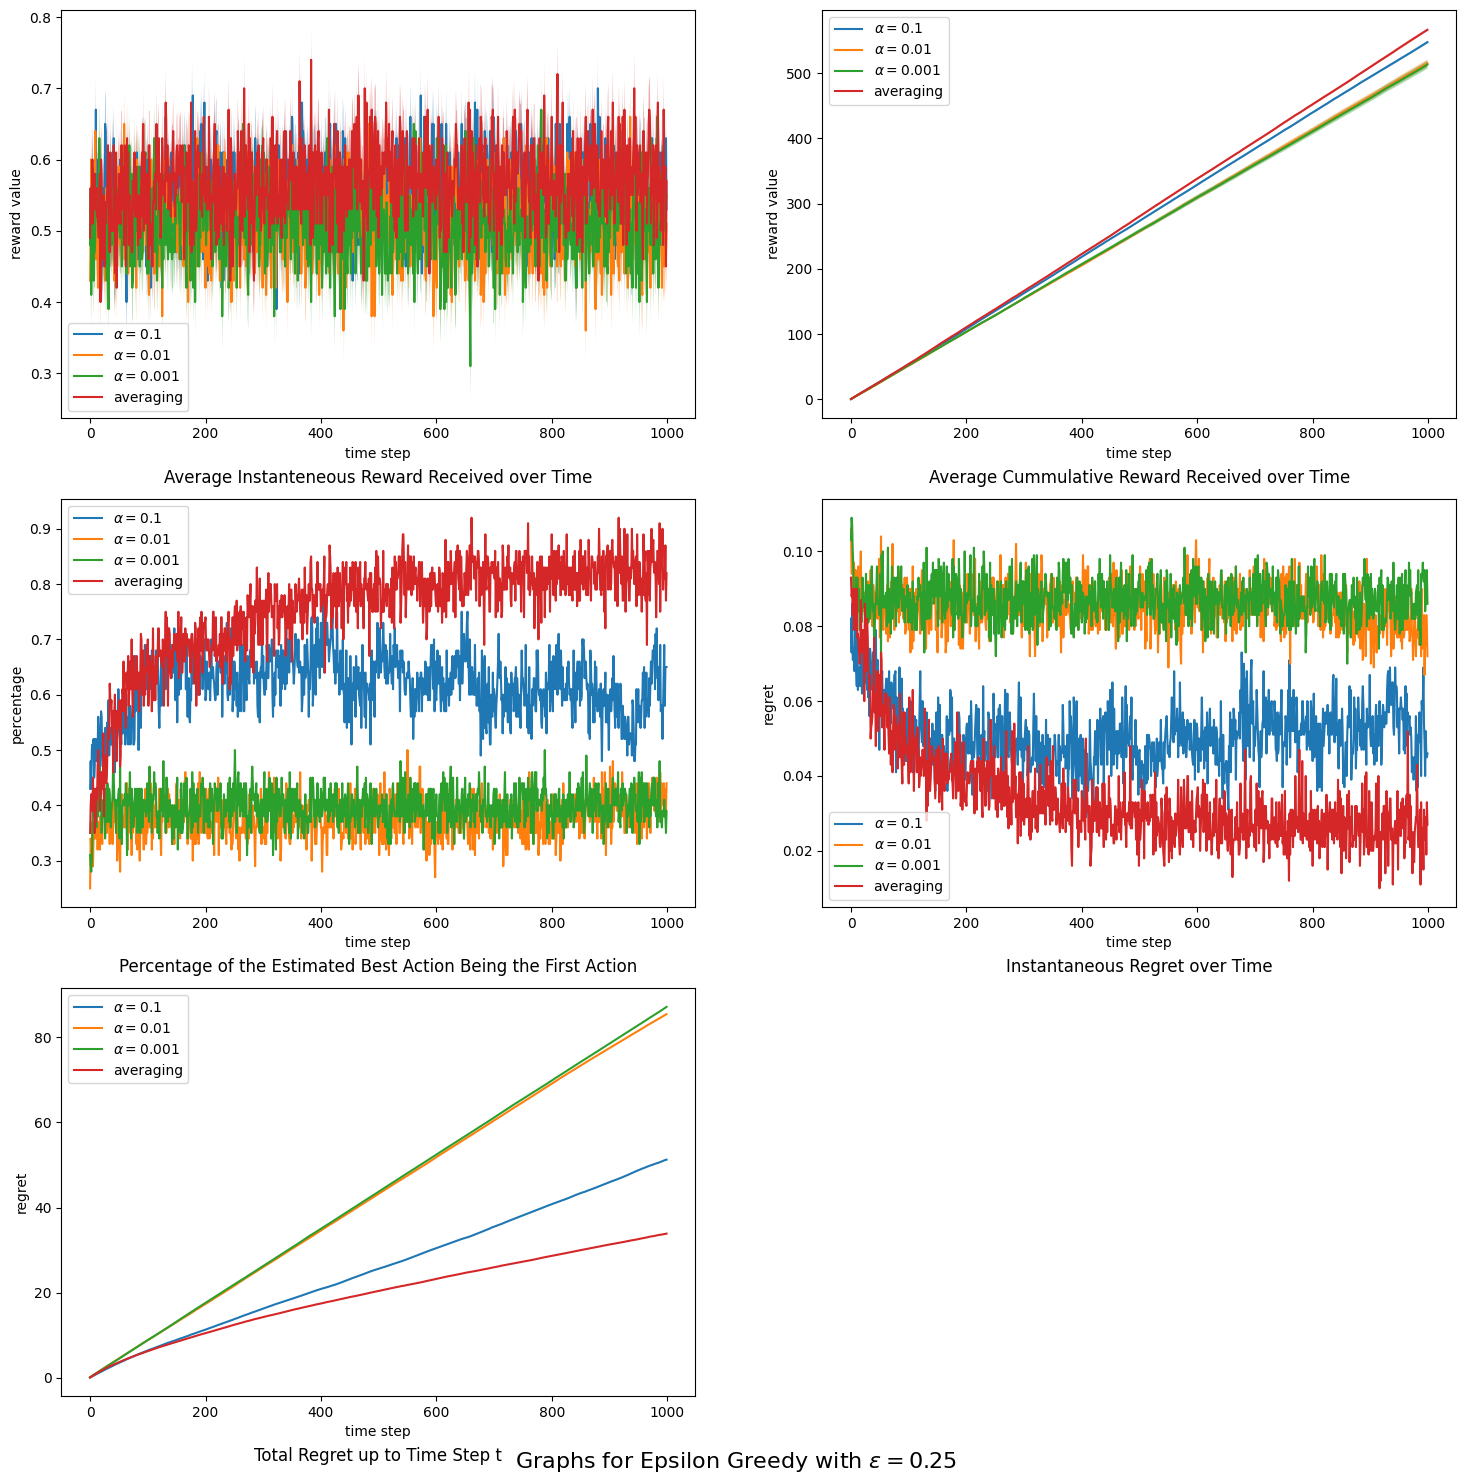

In [11]:
epsilon = 1/4
alphas = [0.1, 0.01, 0.001, None]

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(18, 18))

for alpha in alphas:

  # arrays of the data generated from 100 runs
  R_over_t_runs = []
  total_R_over_t_runs = []
  est_is_best_over_t_runs = []
  l_over_t_runs = []
  total_l_over_t_runs = []

  for run in range(100):
    R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t = epsilon_greedy(three_arm_bernoulli_bandit, epsilon, alpha)

    R_over_t_runs.append(R_over_t)
    total_R_over_t_runs.append(total_R_over_t)
    est_is_best_over_t_runs.append(est_is_best_over_t)
    l_over_t_runs.append(l_over_t)
    total_l_over_t_runs.append(total_l_over_t)

  R_over_t_runs = np.asarray(R_over_t_runs)
  total_R_over_t_runs = np.asarray(total_R_over_t_runs)
  est_is_best_over_t_runs = np.asarray(est_is_best_over_t_runs)
  l_over_t_runs = np.asarray(l_over_t_runs)
  total_l_over_t_runs = np.asarray(total_l_over_t_runs)

  # plot the mean reward over time

  mean_R_over_t_runs = np.mean(R_over_t_runs, axis=0)
  std_err_R_over_t_runs = np.std(R_over_t_runs, axis=0) / np.sqrt(np.size(R_over_t_runs, axis=0))

  axs[0,0].plot(mean_R_over_t_runs, label = r"$\alpha = %s$" %alpha if alpha != None else "averaging")

  R_over_t_minus_std_err = mean_R_over_t_runs - std_err_R_over_t_runs
  R_over_t_plus_std_err = mean_R_over_t_runs  + std_err_R_over_t_runs
  axs[0,0].fill_between(range(0,1000), R_over_t_minus_std_err, R_over_t_plus_std_err, alpha=0.4)
  # axs[0,0].errorbar(range(0,1000), mean_R_over_t_runs, yerr=std_err_R_over_t_runs)

  axs[0,0].legend()
  axs[0,0].set_xlabel("time step")
  axs[0,0].set_ylabel("reward value")
  axs[0,0].set_title("Average Instanteneous Reward Received over Time", y=-0.18)

  # plot the mean cummulative reward over time

  mean_total_R_over_t_runs = np.mean(total_R_over_t_runs, axis=0)
  std_err_total_R_over_t_runs = np.std(total_R_over_t_runs, axis=0) / np.sqrt(np.size(total_R_over_t_runs, axis=0))

  axs[0,1].plot(mean_total_R_over_t_runs, label = r"$\alpha = %s$" %alpha if alpha != None else "averaging")

  total_R_over_t_minus_std_err = mean_total_R_over_t_runs - std_err_total_R_over_t_runs
  total_R_over_t_plus_std_err = mean_total_R_over_t_runs  + std_err_total_R_over_t_runs
  axs[0,1].fill_between(range(0,1000), total_R_over_t_minus_std_err, total_R_over_t_plus_std_err, alpha=0.4)

  axs[0,1].legend()
  axs[0,1].set_xlabel("time step")
  axs[0,1].set_ylabel("reward value")
  axs[0,1].set_title("Average Cummulative Reward Received over Time", y=-0.18)

  #plot the mean percentage of the estimated best action being the first action

  est_is_best_over_t_runs_avgs = np.mean(est_is_best_over_t_runs, axis=0)
  plt_est_is_best_over_t_runs_avgs, = axs[1,0].plot(est_is_best_over_t_runs_avgs, label = r"$\alpha = %s$" %alpha if alpha != None else "averaging")

  axs[1,0].legend()
  axs[1,0].set_xlabel("time step")
  axs[1,0].set_ylabel("percentage")
  axs[1,0].set_title("Percentage of the Estimated Best Action Being the First Action", y=-0.18)

  #plot the mean instantaneous regret over time

  l_over_t_runs_avgs = np.mean(l_over_t_runs, axis=0)
  axs[1,1].plot(l_over_t_runs_avgs, label = r"$\alpha = %s$" %alpha if alpha != None else "averaging")

  axs[1,1].legend()
  axs[1,1].set_xlabel("time step")
  axs[1,1].set_ylabel("regret")
  axs[1,1].set_title("Instantaneous Regret over Time", y=-0.18)

  #plot the total regret over time

  total_l_over_t_runs_avgs = np.mean(total_l_over_t_runs, axis=0)
  axs[2,0].plot(total_l_over_t_runs_avgs, label = r"$\alpha = %s$" %alpha if alpha != None else "averaging")

  axs[2,0].legend()
  axs[2,0].set_xlabel("time step")
  axs[2,0].set_ylabel("regret")
  axs[2,0].set_title("Total Regret up to Time Step t", y=-0.18)

axs[-1, -1].axis('off')

title = r"Graphs for Epsilon Greedy with $\epsilon = %s$" %epsilon
fig.suptitle(title, fontsize=16, y=0.08)

plt.show()

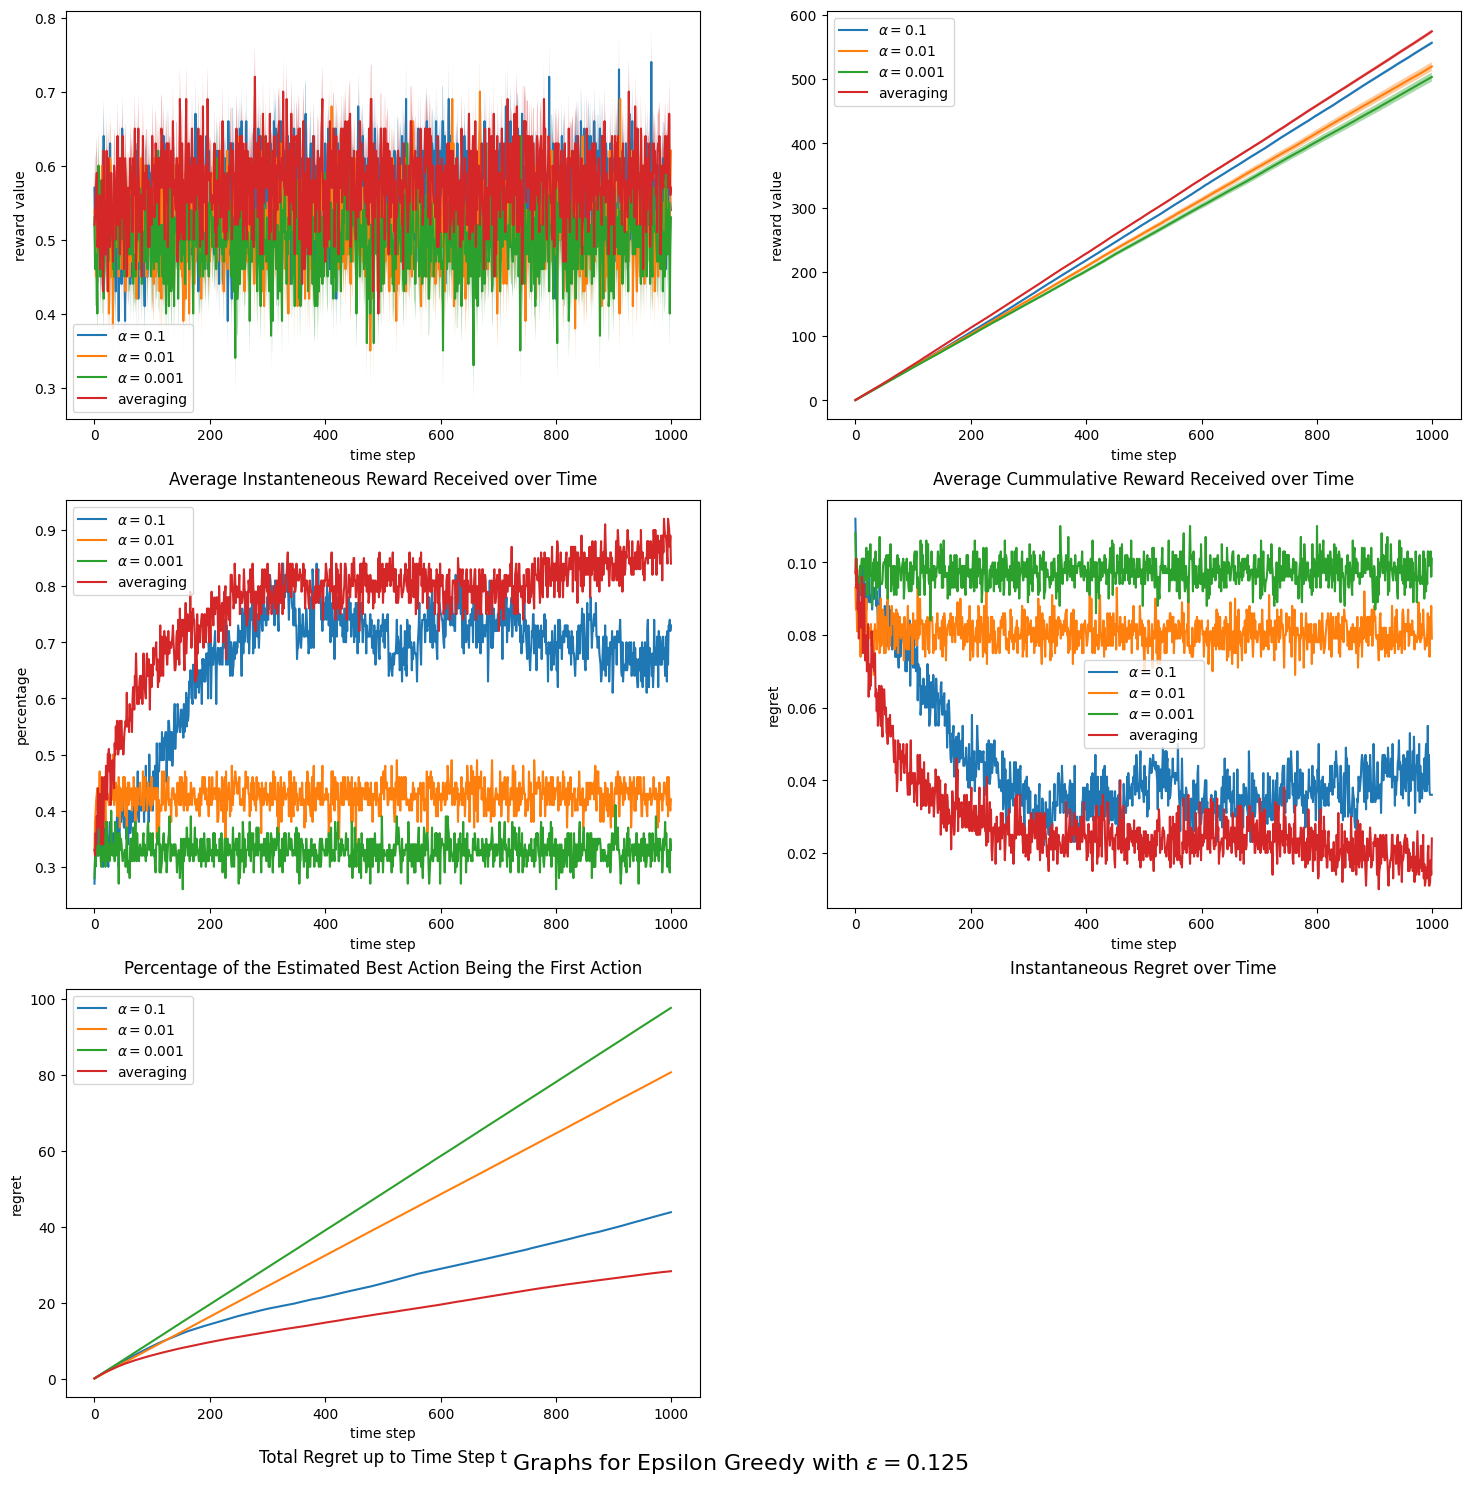

In [12]:
epsilon = 1/8
alphas = [0.1, 0.01, 0.001, None]

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(18, 18))

for alpha in alphas:

  # arrays of the data generated from 100 runs
  R_over_t_runs = []
  total_R_over_t_runs = []
  est_is_best_over_t_runs = []
  l_over_t_runs = []
  total_l_over_t_runs = []

  for run in range(100):
    R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t = epsilon_greedy(three_arm_bernoulli_bandit, epsilon, alpha)

    R_over_t_runs.append(R_over_t)
    total_R_over_t_runs.append(total_R_over_t)
    est_is_best_over_t_runs.append(est_is_best_over_t)
    l_over_t_runs.append(l_over_t)
    total_l_over_t_runs.append(total_l_over_t)

  R_over_t_runs = np.asarray(R_over_t_runs)
  total_R_over_t_runs = np.asarray(total_R_over_t_runs)
  est_is_best_over_t_runs = np.asarray(est_is_best_over_t_runs)
  l_over_t_runs = np.asarray(l_over_t_runs)
  total_l_over_t_runs = np.asarray(total_l_over_t_runs)

  # plot the mean reward over time

  mean_R_over_t_runs = np.mean(R_over_t_runs, axis=0)
  std_err_R_over_t_runs = np.std(R_over_t_runs, axis=0) / np.sqrt(np.size(R_over_t_runs, axis=0))

  axs[0,0].plot(mean_R_over_t_runs, label = r"$\alpha = %s$" %alpha if alpha != None else "averaging")

  R_over_t_minus_std_err = mean_R_over_t_runs - std_err_R_over_t_runs
  R_over_t_plus_std_err = mean_R_over_t_runs  + std_err_R_over_t_runs
  axs[0,0].fill_between(range(0,1000), R_over_t_minus_std_err, R_over_t_plus_std_err, alpha=0.4)
  # axs[0,0].errorbar(range(0,1000), mean_R_over_t_runs, yerr=std_err_R_over_t_runs)

  axs[0,0].legend()
  axs[0,0].set_xlabel("time step")
  axs[0,0].set_ylabel("reward value")
  axs[0,0].set_title("Average Instanteneous Reward Received over Time", y=-0.18)

  # plot the mean cummulative reward over time

  mean_total_R_over_t_runs = np.mean(total_R_over_t_runs, axis=0)
  std_err_total_R_over_t_runs = np.std(total_R_over_t_runs, axis=0) / np.sqrt(np.size(total_R_over_t_runs, axis=0))

  axs[0,1].plot(mean_total_R_over_t_runs, label = r"$\alpha = %s$" %alpha if alpha != None else "averaging")

  total_R_over_t_minus_std_err = mean_total_R_over_t_runs - std_err_total_R_over_t_runs
  total_R_over_t_plus_std_err = mean_total_R_over_t_runs  + std_err_total_R_over_t_runs
  axs[0,1].fill_between(range(0,1000), total_R_over_t_minus_std_err, total_R_over_t_plus_std_err, alpha=0.4)

  axs[0,1].legend()
  axs[0,1].set_xlabel("time step")
  axs[0,1].set_ylabel("reward value")
  axs[0,1].set_title("Average Cummulative Reward Received over Time", y=-0.18)

  #plot the mean percentage of the estimated best action being the first action

  est_is_best_over_t_runs_avgs = np.mean(est_is_best_over_t_runs, axis=0)
  plt_est_is_best_over_t_runs_avgs, = axs[1,0].plot(est_is_best_over_t_runs_avgs, label = r"$\alpha = %s$" %alpha if alpha != None else "averaging")

  axs[1,0].legend()
  axs[1,0].set_xlabel("time step")
  axs[1,0].set_ylabel("percentage")
  axs[1,0].set_title("Percentage of the Estimated Best Action Being the First Action", y=-0.18)

  #plot the mean instantaneous regret over time

  l_over_t_runs_avgs = np.mean(l_over_t_runs, axis=0)
  axs[1,1].plot(l_over_t_runs_avgs, label = r"$\alpha = %s$" %alpha if alpha != None else "averaging")

  axs[1,1].legend()
  axs[1,1].set_xlabel("time step")
  axs[1,1].set_ylabel("regret")
  axs[1,1].set_title("Instantaneous Regret over Time", y=-0.18)

  #plot the total regret over time

  total_l_over_t_runs_avgs = np.mean(total_l_over_t_runs, axis=0)
  axs[2,0].plot(total_l_over_t_runs_avgs, label = r"$\alpha = %s$" %alpha if alpha != None else "averaging")

  axs[2,0].legend()
  axs[2,0].set_xlabel("time step")
  axs[2,0].set_ylabel("regret")
  axs[2,0].set_title("Total Regret up to Time Step t", y=-0.18)

axs[-1, -1].axis('off')

title = r"Graphs for Epsilon Greedy with $\epsilon = %s$" %epsilon
fig.suptitle(title, fontsize=16, y=0.08)

plt.show()

### Q5 - Results Analysis:

For both values of epsilon, the incremental averaging method outperforms constant learning rate methods, achieving higher average rewards and lower cumulative regret. A higher alpha of 0.1 closely rivals the performance of averaging, whereas the smallest alpha of 0.001 yields significantly higher regret and lower rewards, indicating less effective learning.

## Q6 UCB

In [23]:
def UCB(bandit, c = 2, alpha = None, num_time_step = 1000, non_stationary = False):
  """Upper confidence bound algorithm for bandit action selection

  Parameters
  ----------
  bandit : bandit class
      A bernoulli bandit attributes num_arms and probs_arr, and method sample
  c: int
      A parameter which determines the degree of exploration, the higher the c the higher the tendency for
      the algorithm to explore potentially suboptimal actionss
  alpha: (optional) float
      A parameter which determined the learning rate for averaging. If alpha is none, incremental averaging is used.
      Default is none, corresponding to incremental averaging.
  non_stationary: (optional) boolean
        A parameter which determines whether the bandit is non-stationary. If true, the bandit is non-stationary.

  Returns
  -------
  R_over_t
      a list of instantaneous return over the time steps
  total_R_over_t
      a list of cummulative reward over the time steps
  est_is_best_over_t
      a list of values of 0 and 1 where 1 indicates the estimated best action is the true best action and 0 otherwise for each time step
  l_over_t
      a list of instanteneous regret over the time steps
  total_l_over_t
      a list of cummulative regret over the time steps
  """

  num_arms = bandit.num_arms

  Q_arr = np.zeros(num_arms) # array of estimated average reward for each action
  N_arr = np.zeros(num_arms) # array of number of times picked for each action
  total_R = 0
  total_l = 0
  actions = range(num_arms)

  opt_value = max(bandit.probs_arr) # highest expected reward among all actions
  best_action = np.argmax(bandit.probs_arr) # the index of the action with highest expected reward

  R_over_t = []
  total_R_over_t = []
  est_is_best_over_t = []
  l_over_t = []
  total_l_over_t = []

  for time_step in range(num_time_step):
    # If in non-stationnary, after 500 time steps, the parameter of actions 2 and 3 become 0:5 + delta * 2  and 0:5 + delta * 3 respectively
    if non_stationary and time_step == 500:
        bandit.probs_arr[1] = 0.5 + delta * 2
        bandit.probs_arr[2] = 0.5 + delta * 3    

    # Try all actions initially
    if time_step < num_arms:
      A = time_step
      curr_R = bandit.sample(A)
      N_arr[A] = N_arr[A] + 1
    else:
      UCB = Q_arr + c * np.sqrt(np.log(time_step) / N_arr)
      max_UCB = max(UCB)
      A = np.random.choice([i for i, ucb in enumerate(UCB) if ucb == max_UCB]) # random tie-breaking
      curr_R = bandit.sample(A)
      N_arr[A] = N_arr[A] + 1

    if alpha == None:
      # incremental averaging
      Q_arr[A] = Q_arr[A] + (1 / N_arr[A]) * (curr_R - Q_arr[A])
    else:
      Q_arr[A] = Q_arr[A] + alpha * (curr_R - Q_arr[A])

    R_over_t.append(curr_R)

    total_R = total_R + curr_R
    total_R_over_t.append(total_R)

    est_is_best = 1 if A == best_action else 0
    est_is_best_over_t.append(est_is_best)

    # Calculate instantaneous regret as the difference between optimal and expected reward of the action taken
    l_t = opt_value - bandit.probs_arr[A] 
    l_over_t.append(l_t)

    total_l = total_l + l_t
    total_l_over_t.append(total_l)

  return R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t

### Graphs

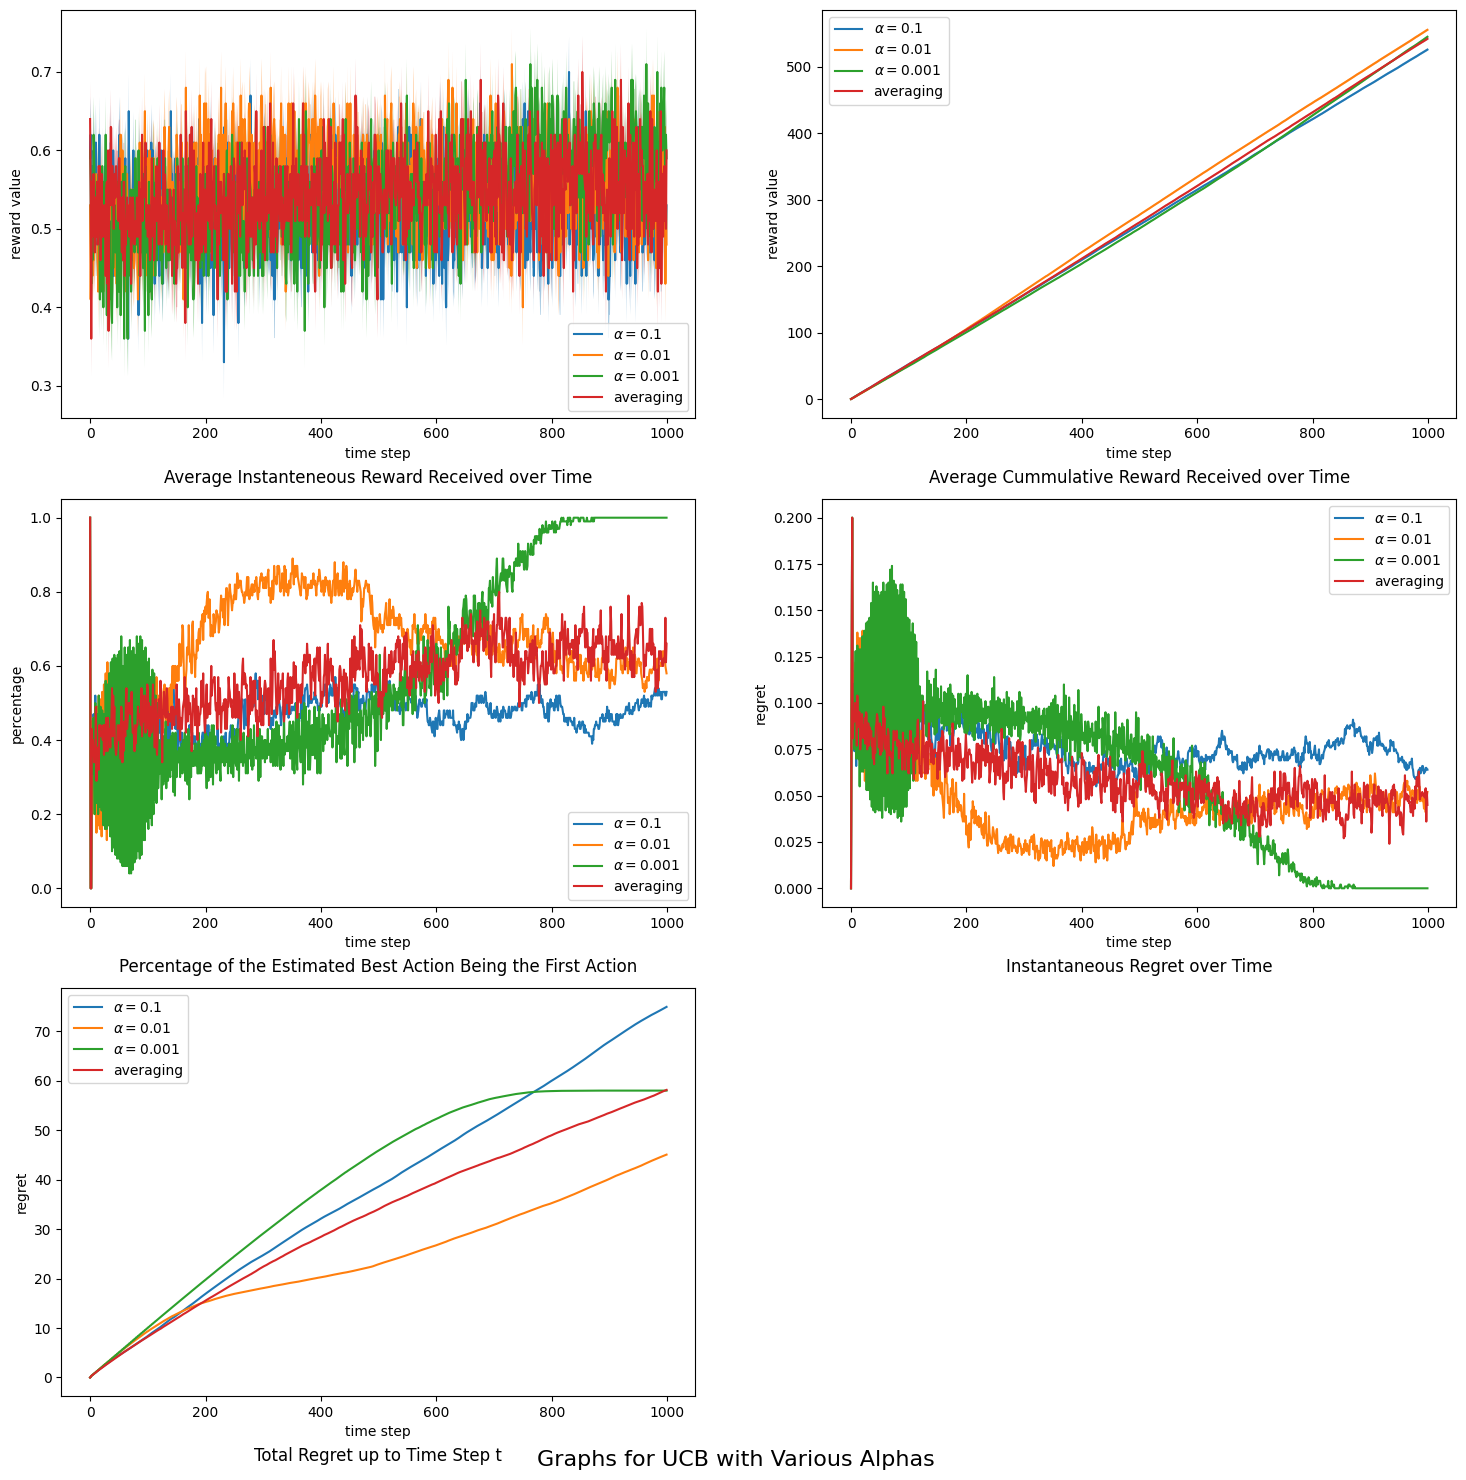

In [26]:
c = 2
alphas = [0.1, 0.01, 0.001, None]

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(18, 18))

for alpha in alphas:

  # arrays of the data generated from 100 runs
  R_over_t_runs = []
  total_R_over_t_runs = []
  est_is_best_over_t_runs = []
  l_over_t_runs = []
  total_l_over_t_runs = []

  for run in range(100):
    R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t = UCB(three_arm_bernoulli_bandit, c, alpha)

    R_over_t_runs.append(R_over_t)
    total_R_over_t_runs.append(total_R_over_t)
    est_is_best_over_t_runs.append(est_is_best_over_t)
    l_over_t_runs.append(l_over_t)
    total_l_over_t_runs.append(total_l_over_t)

  R_over_t_runs = np.asarray(R_over_t_runs)
  total_R_over_t_runs = np.asarray(total_R_over_t_runs)
  est_is_best_over_t_runs = np.asarray(est_is_best_over_t_runs)
  l_over_t_runs = np.asarray(l_over_t_runs)
  total_l_over_t_runs = np.asarray(total_l_over_t_runs)

  # plot the mean reward over time

  mean_R_over_t_runs = np.mean(R_over_t_runs, axis=0)
  std_err_R_over_t_runs = np.std(R_over_t_runs, axis=0) / np.sqrt(np.size(R_over_t_runs, axis=0))

  axs[0,0].plot(mean_R_over_t_runs, label = r"$\alpha = %s$" %alpha if alpha != None else "averaging")

  R_over_t_minus_std_err = mean_R_over_t_runs - std_err_R_over_t_runs
  R_over_t_plus_std_err = mean_R_over_t_runs  + std_err_R_over_t_runs
  axs[0,0].fill_between(range(0,1000), R_over_t_minus_std_err, R_over_t_plus_std_err, alpha=0.4)
  # axs[0,0].errorbar(range(0,1000), mean_R_over_t_runs, yerr=std_err_R_over_t_runs)

  axs[0,0].legend()
  axs[0,0].set_xlabel("time step")
  axs[0,0].set_ylabel("reward value")
  axs[0,0].set_title("Average Instanteneous Reward Received over Time", y=-0.18)

  # plot the mean cummulative reward over time

  mean_total_R_over_t_runs = np.mean(total_R_over_t_runs, axis=0)
  std_err_total_R_over_t_runs = np.std(total_R_over_t_runs, axis=0) / np.sqrt(np.size(total_R_over_t_runs, axis=0))

  axs[0,1].plot(mean_total_R_over_t_runs, label = r"$\alpha = %s$" %alpha if alpha != None else "averaging")

  total_R_over_t_minus_std_err = mean_total_R_over_t_runs - std_err_total_R_over_t_runs
  total_R_over_t_plus_std_err = mean_total_R_over_t_runs  + std_err_total_R_over_t_runs
  axs[0,1].fill_between(range(0,1000), total_R_over_t_minus_std_err, total_R_over_t_plus_std_err, alpha=0.4)

  axs[0,1].legend()
  axs[0,1].set_xlabel("time step")
  axs[0,1].set_ylabel("reward value")
  axs[0,1].set_title("Average Cummulative Reward Received over Time", y=-0.18)

  #plot the mean percentage of the estimated best action being the first action

  est_is_best_over_t_runs_avgs = np.mean(est_is_best_over_t_runs, axis=0)
  plt_est_is_best_over_t_runs_avgs, = axs[1,0].plot(est_is_best_over_t_runs_avgs, label = r"$\alpha = %s$" %alpha if alpha != None else "averaging")

  axs[1,0].legend()
  axs[1,0].set_xlabel("time step")
  axs[1,0].set_ylabel("percentage")
  axs[1,0].set_title("Percentage of the Estimated Best Action Being the First Action", y=-0.18)

  #plot the mean instantaneous regret over time

  l_over_t_runs_avgs = np.mean(l_over_t_runs, axis=0)
  axs[1,1].plot(l_over_t_runs_avgs, label = r"$\alpha = %s$" %alpha if alpha != None else "averaging")

  axs[1,1].legend()
  axs[1,1].set_xlabel("time step")
  axs[1,1].set_ylabel("regret")
  axs[1,1].set_title("Instantaneous Regret over Time", y=-0.18)

  #plot the total regret over time

  total_l_over_t_runs_avgs = np.mean(total_l_over_t_runs, axis=0)
  axs[2,0].plot(total_l_over_t_runs_avgs, label = r"$\alpha = %s$" %alpha if alpha != None else "averaging")

  axs[2,0].legend()
  axs[2,0].set_xlabel("time step")
  axs[2,0].set_ylabel("regret")
  axs[2,0].set_title("Total Regret up to Time Step t", y=-0.18)

axs[-1, -1].axis('off')

title = r"Graphs for UCB with Various Alphas"
# title = r"Graphs for UCB with Various Alphas and $c = %s$" %c
fig.suptitle(title, fontsize=16, y=0.08)

plt.show()

### Answers

For the UCB algorithm, it is not exaclty clear which method is best. In terms of regret, the learning rate method with $\alpha = 0.01$ seems to be the best over time but after around 800 time steps, the learning rate method with $\alpha = 0.001$ approaches an instantaneous regret of 0. The method with $\alpha = 0.001$ also ends up always picking the best action. In terms of average reward, the learning rate method with $\alpha = 0.01$ seems to be the best with $\alpha = 0.001$ being the second best candidate.

## Q7 Thompson Sampling

In [28]:
def Thompson_sampling(bandit, num_time_step = 1000, non_stationary = False):
  """Thompson sampling algorithm for bandit action selection

  Parameters
  ----------
  bandit : bandit class
      A bernoulli bandit attributes num_arms and probs_arr, and method sample

  Returns
  -------
  R_over_t
      a list of instantaneous return over the time steps
  total_R_over_t
      a list of cummulative reward over the time steps
  est_is_best_over_t
      a list of values of 0 and 1 where 1 indicates the estimated best action is the true best action and 0 otherwise for each time step
  l_over_t
      a list of instanteneous regret over the time steps
  total_l_over_t
      a list of cummulative regret over the time steps
  """
  num_arms = bandit.num_arms
  successes = np.zeros(num_arms)  # Number of successes for each arm
  failures = np.zeros(num_arms)   # Number of failures for each arm

  # Lists to store the results
  R_over_t = []
  total_R_over_t = []
  est_is_best_over_t = []
  l_over_t = []
  total_l_over_t = []

  total_R = 0
  total_l = 0
  opt_value = max(bandit.probs_arr)
  best_action = np.argmax(bandit.probs_arr)

  for time_step in range(num_time_step):
    # If in non-stationnary, after 500 time steps, the parameter of actions 2 and 3 become 0:5 + delta * 2  and 0:5 + delta * 3 respectively
    if non_stationary and time_step == 500:
        bandit.probs_arr[1] = 0.5 + delta * 2
        bandit.probs_arr[2] = 0.5 + delta * 3
        
    # Sample from the beta distribution for each arm
    theta_sample = np.random.beta(1 + successes, 1 + failures)
    A = np.argmax(theta_sample)  # Choose the arm with the highest sample
    reward = bandit.sample(A) # Obseerve reward r_i from arm i we chose

    # Update successes and failures
    if reward == 1:
        successes[A] += 1
    else:
        failures[A] += 1

    # Update metrics
    R_over_t.append(reward)
    total_R += reward
    total_R_over_t.append(total_R)
    est_is_best = 1 if A == best_action else 0
    est_is_best_over_t.append(est_is_best)

    # Calculate instantaneous regret as the difference between optimal and expected reward of the action taken
    l_t = opt_value - bandit.probs_arr[A]     
    l_over_t.append(l_t)
    total_l += l_t
    total_l_over_t.append(total_l)
  
  return R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t

### Graphs

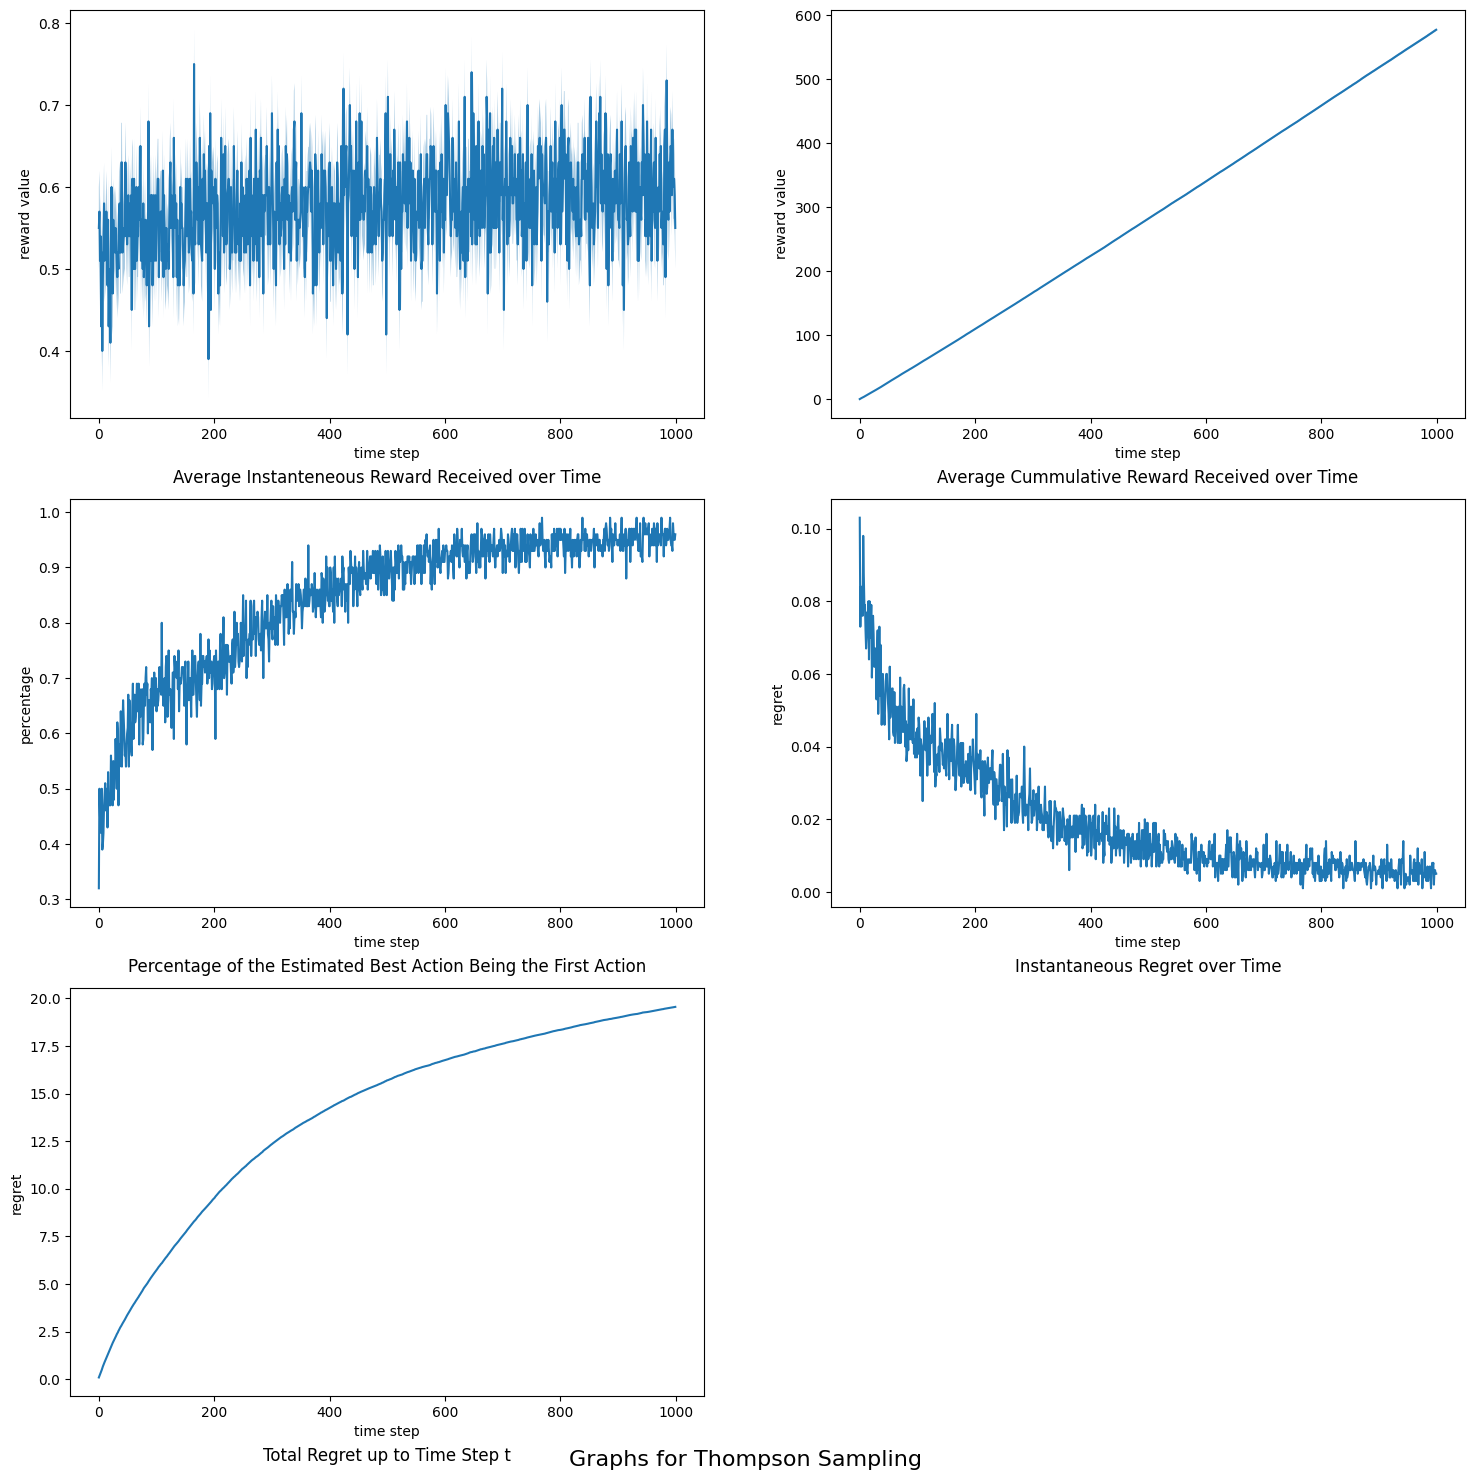

In [16]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(18, 18))

# arrays of the data generated from 100 runs
R_over_t_runs = []
total_R_over_t_runs = []
est_is_best_over_t_runs = []
l_over_t_runs = []
total_l_over_t_runs = []

for run in range(100):
  R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t = Thompson_sampling(three_arm_bernoulli_bandit)

  R_over_t_runs.append(R_over_t)
  total_R_over_t_runs.append(total_R_over_t)
  est_is_best_over_t_runs.append(est_is_best_over_t)
  l_over_t_runs.append(l_over_t)
  total_l_over_t_runs.append(total_l_over_t)

R_over_t_runs = np.asarray(R_over_t_runs)
total_R_over_t_runs = np.asarray(total_R_over_t_runs)
est_is_best_over_t_runs = np.asarray(est_is_best_over_t_runs)
l_over_t_runs = np.asarray(l_over_t_runs)
total_l_over_t_runs = np.asarray(total_l_over_t_runs)

# plot the mean reward over time

mean_R_over_t_runs = np.mean(R_over_t_runs, axis=0)
std_err_R_over_t_runs = np.std(R_over_t_runs, axis=0) / np.sqrt(np.size(R_over_t_runs, axis=0))

axs[0,0].plot(mean_R_over_t_runs)

R_over_t_minus_std_err = mean_R_over_t_runs - std_err_R_over_t_runs
R_over_t_plus_std_err = mean_R_over_t_runs  + std_err_R_over_t_runs
axs[0,0].fill_between(range(0,1000), R_over_t_minus_std_err, R_over_t_plus_std_err, alpha=0.4)
# axs[0,0].errorbar(range(0,1000), mean_R_over_t_runs, yerr=std_err_R_over_t_runs)

axs[0,0].set_xlabel("time step")
axs[0,0].set_ylabel("reward value")
axs[0,0].set_title("Average Instanteneous Reward Received over Time", y=-0.18)

# plot the mean cummulative reward over time

mean_total_R_over_t_runs = np.mean(total_R_over_t_runs, axis=0)
std_err_total_R_over_t_runs = np.std(total_R_over_t_runs, axis=0) / np.sqrt(np.size(total_R_over_t_runs, axis=0))

axs[0,1].plot(mean_total_R_over_t_runs)

total_R_over_t_minus_std_err = mean_total_R_over_t_runs - std_err_total_R_over_t_runs
total_R_over_t_plus_std_err = mean_total_R_over_t_runs  + std_err_total_R_over_t_runs
axs[0,1].fill_between(range(0,1000), total_R_over_t_minus_std_err, total_R_over_t_plus_std_err, alpha=0.4)

axs[0,1].set_xlabel("time step")
axs[0,1].set_ylabel("reward value")
axs[0,1].set_title("Average Cummulative Reward Received over Time", y=-0.18)

#plot the mean percentage of the estimated best action being the first action

est_is_best_over_t_runs_avgs = np.mean(est_is_best_over_t_runs, axis=0)
plt_est_is_best_over_t_runs_avgs, = axs[1,0].plot(est_is_best_over_t_runs_avgs)

axs[1,0].set_xlabel("time step")
axs[1,0].set_ylabel("percentage")
axs[1,0].set_title("Percentage of the Estimated Best Action Being the First Action", y=-0.18)

#plot the mean instantaneous regret over time

l_over_t_runs_avgs = np.mean(l_over_t_runs, axis=0)
axs[1,1].plot(l_over_t_runs_avgs,)

axs[1,1].set_xlabel("time step")
axs[1,1].set_ylabel("regret")
axs[1,1].set_title("Instantaneous Regret over Time", y=-0.18)

#plot the total regret over time

total_l_over_t_runs_avgs = np.mean(total_l_over_t_runs, axis=0)
axs[2,0].plot(total_l_over_t_runs_avgs)

axs[2,0].set_xlabel("time step")
axs[2,0].set_ylabel("regret")
axs[2,0].set_title("Total Regret up to Time Step t", y=-0.18)

axs[-1, -1].axis('off')

title = "Graphs for Thompson Sampling"
fig.suptitle(title, fontsize=16, y=0.08)

plt.show()

### Q7 - Results Analysis:

Thompson Sampling algorithm's instantaneous regret diminishes as time progresses, almost approaching zero, which suggests that it becomes increasingly effective at selecting the best action. Moreover, the total cumulative regret seems to be the lowest among all algorithsm explored so far, since it does not exceed 20. Finally, the percentage of times the best action is chosen is increasing over time and is almost 100% at the end of the experiment, which indicates that the algorithm is able to identify the best action with high confidence.

## Q8 Comparison of Algorithms

Here are the explanations about how we chose the hyperparameters for each algorithm:
- For epsilon-greedy, we chose $\epsilon = 0.125$ as it was shown in the results of question 4 to have the lowest total cumulative regret and highest total cumulative reward. We also chose the incremental averaging method as it was shown in the results of question 5 to have the lowest total cumulative regret and highest total cumulative reward as well.
- For UCB, we chose to use the learning rate method with $\alpha = 0.01$ since it was shown in the results of question 6 to have the lowest total cumulative regret and the best total cumulative reward. 
- The Thompson Sampling algorithm did not have any hyperparameters to choose from.

### Graphs

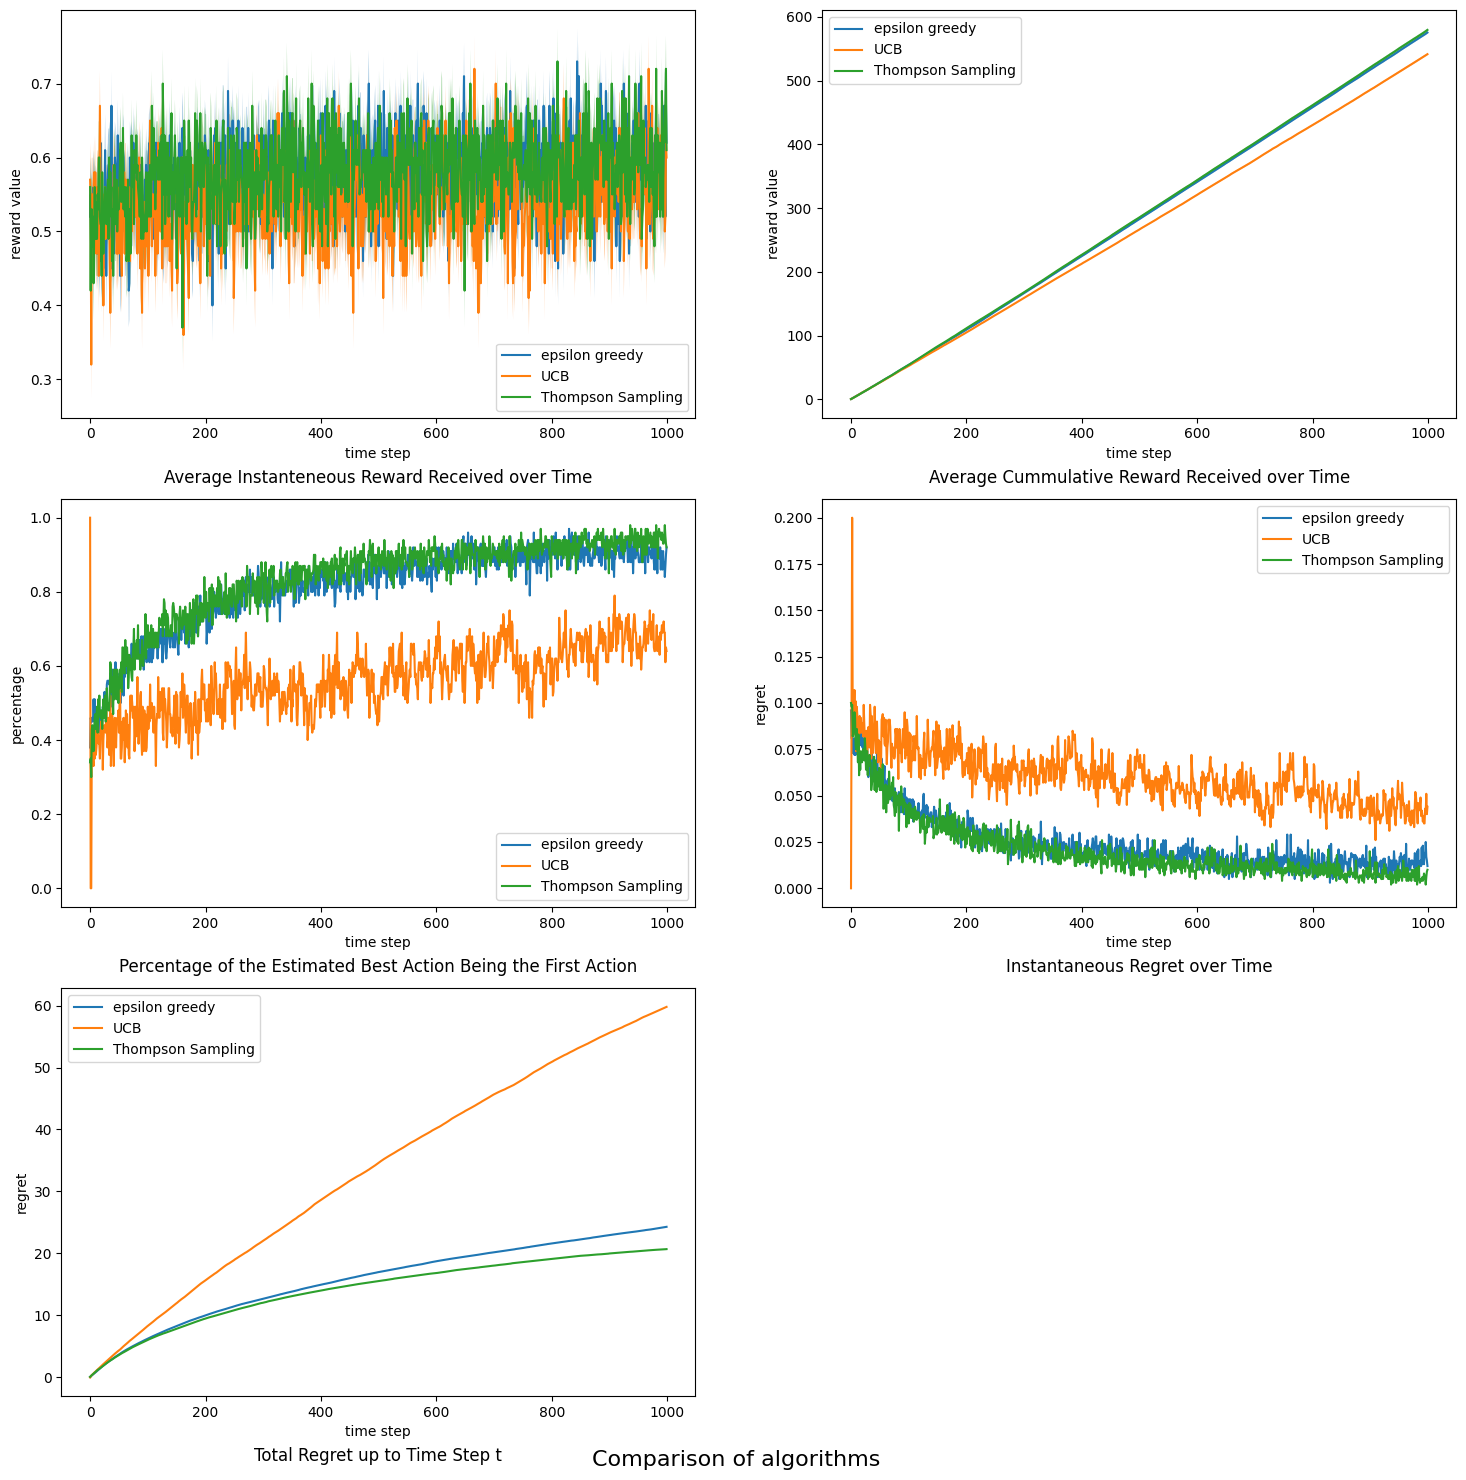

In [17]:
experiments = ["epsilon greedy", "UCB", "Thompson Sampling"]

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(18, 18))

for experiment in experiments:

  # arrays of the data generated from 1000 runs for each experiment
  R_over_t_runs = []
  total_R_over_t_runs = []
  est_is_best_over_t_runs = []
  l_over_t_runs = []
  total_l_over_t_runs = []

  for run in range(100):
    if experiment == "epsilon greedy":
      # Run epsilon greedy with epsilon = 0.125 for 1000 time steps 
      R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t = epsilon_greedy(three_arm_bernoulli_bandit, 0.125)
    elif experiment == "UCB": 
      R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t = UCB(three_arm_bernoulli_bandit, c=2, alpha=0.01)
    elif experiment == "Thompson Sampling":
      R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t = Thompson_sampling(three_arm_bernoulli_bandit)

    R_over_t_runs.append(R_over_t)
    total_R_over_t_runs.append(total_R_over_t)
    est_is_best_over_t_runs.append(est_is_best_over_t)
    l_over_t_runs.append(l_over_t)
    total_l_over_t_runs.append(total_l_over_t)

  R_over_t_runs = np.asarray(R_over_t_runs)
  total_R_over_t_runs = np.asarray(total_R_over_t_runs)
  est_is_best_over_t_runs = np.asarray(est_is_best_over_t_runs)
  l_over_t_runs = np.asarray(l_over_t_runs)
  total_l_over_t_runs = np.asarray(total_l_over_t_runs)

  # plot the mean reward over time

  mean_R_over_t_runs = np.mean(R_over_t_runs, axis=0)
  std_err_R_over_t_runs = np.std(R_over_t_runs, axis=0) / np.sqrt(np.size(R_over_t_runs, axis=0))

  axs[0,0].plot(mean_R_over_t_runs, label = experiment)

  R_over_t_minus_std_err = mean_R_over_t_runs - std_err_R_over_t_runs
  R_over_t_plus_std_err = mean_R_over_t_runs  + std_err_R_over_t_runs
  axs[0,0].fill_between(range(0,1000), R_over_t_minus_std_err, R_over_t_plus_std_err, alpha=0.4)
  # axs[0,0].errorbar(range(0,1000), mean_R_over_t_runs, yerr=std_err_R_over_t_runs)

  axs[0,0].legend()
  axs[0,0].set_xlabel("time step")
  axs[0,0].set_ylabel("reward value")
  axs[0,0].set_title("Average Instanteneous Reward Received over Time", y=-0.18)

  # plot the mean cummulative reward over time

  mean_total_R_over_t_runs = np.mean(total_R_over_t_runs, axis=0)
  std_err_total_R_over_t_runs = np.std(total_R_over_t_runs, axis=0) / np.sqrt(np.size(total_R_over_t_runs, axis=0))

  axs[0,1].plot(mean_total_R_over_t_runs, label = experiment)

  total_R_over_t_minus_std_err = mean_total_R_over_t_runs - std_err_total_R_over_t_runs
  total_R_over_t_plus_std_err = mean_total_R_over_t_runs  + std_err_total_R_over_t_runs
  axs[0,1].fill_between(range(0,1000), total_R_over_t_minus_std_err, total_R_over_t_plus_std_err, alpha=0.4)

  axs[0,1].legend()
  axs[0,1].set_xlabel("time step")
  axs[0,1].set_ylabel("reward value")
  axs[0,1].set_title("Average Cummulative Reward Received over Time", y=-0.18)

  #plot the mean percentage of the estimated best action being the first action

  est_is_best_over_t_runs_avgs = np.mean(est_is_best_over_t_runs, axis=0)
  plt_est_is_best_over_t_runs_avgs, = axs[1,0].plot(est_is_best_over_t_runs_avgs, label = experiment)

  axs[1,0].legend()
  axs[1,0].set_xlabel("time step")
  axs[1,0].set_ylabel("percentage")
  axs[1,0].set_title("Percentage of the Estimated Best Action Being the First Action", y=-0.18)

  #plot the mean instantaneous regret over time

  l_over_t_runs_avgs = np.mean(l_over_t_runs, axis=0)
  axs[1,1].plot(l_over_t_runs_avgs, label = experiment)

  axs[1,1].legend()
  axs[1,1].set_xlabel("time step")
  axs[1,1].set_ylabel("regret")
  axs[1,1].set_title("Instantaneous Regret over Time", y=-0.18)

  #plot the total regret over time

  total_l_over_t_runs_avgs = np.mean(total_l_over_t_runs, axis=0)
  axs[2,0].plot(total_l_over_t_runs_avgs, label = experiment)

  axs[2,0].legend()
  axs[2,0].set_xlabel("time step")
  axs[2,0].set_ylabel("regret")
  axs[2,0].set_title("Total Regret up to Time Step t", y=-0.18)

axs[-1, -1].axis('off')

title = r"Comparison of algorithms"
fig.suptitle(title, fontsize=16, y=0.08)

plt.show()

### Q8 - Results Analysis:

The obtained graphs indicate that Thompson Sampling outperforms the other algorithms, achieving the lowest total and instantaneous regret, as well as the highest cumulative reward over time. This suggests that Thompson Sampling is more effective at correctly identifying and sticking with the best action, which is also shown by the high percentage of times the estimated best action is the first choice. Moreover, the epsilon-greedy algorithm achieves similar results, with its total cumulative regret only slightly higher than Thompson Sampling by the 1000th time step. UCB, however, results in more regret and less reward over time, which reflects its relatively less accurate estimation of the best action. 

## Q9 Non-stationary Environment

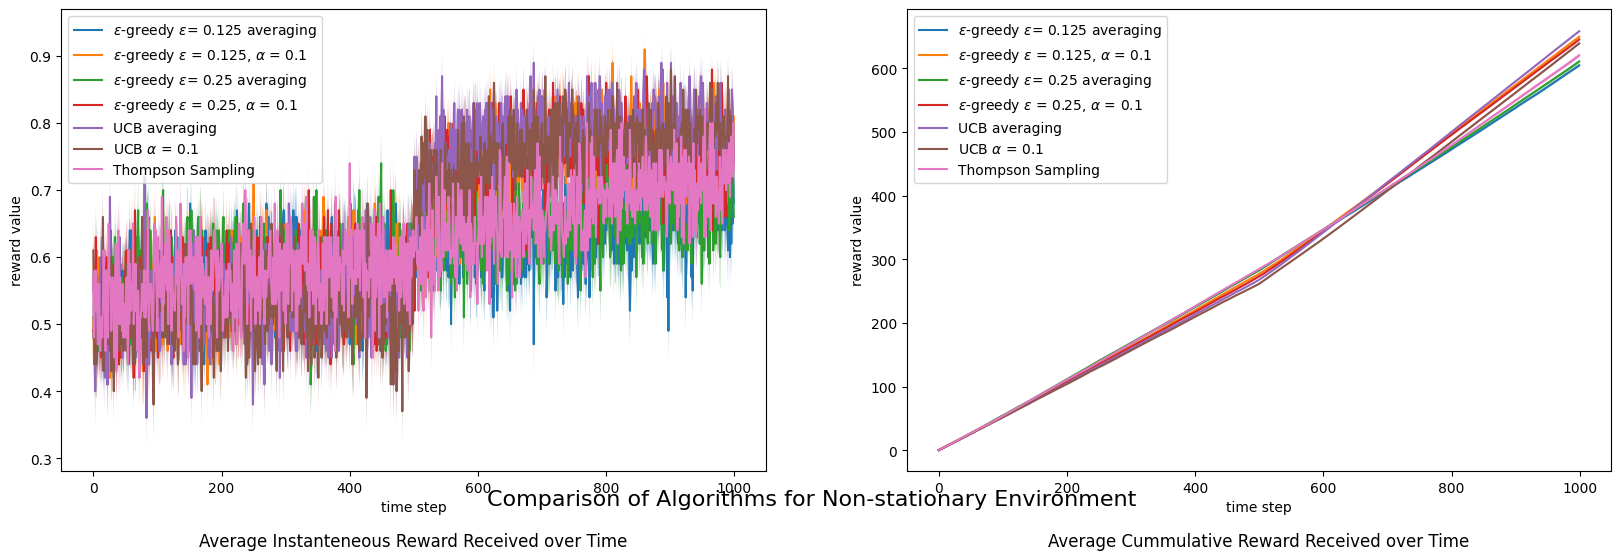

In [19]:
# Define hyperparameters for each algorithm
epsilon_greedy_experiments = [
    {'epsilon': 0.125, 'learning_rate': None},
    {'epsilon': 0.125, 'learning_rate': 0.1},
    {'epsilon': 0.25, 'learning_rate': None},
    {'epsilon': 0.25, 'learning_rate': 0.1}
]

UCB_experiments = [
    {'learning_rate': None},
    {'learning_rate': 0.1}
]

# Combine all experiments into a single array
experiments = [ 
  {'name': "epsilon greedy", 'params': exp} for exp in epsilon_greedy_experiments
] + [
    {'name': "UCB", 'params': exp} for exp in UCB_experiments
] + [
    {'name': "Thompson Sampling", 'params': None}
]

fig, axs = plt.subplots(ncols=2, figsize=(20, 6))

for experiment in experiments:
  name = experiment['name']
  params = experiment['params']
  experiment_name = ""

  # arrays of the data generated from 1000 runs for each experiment
  R_over_t_runs = []
  total_R_over_t_runs = []
  est_is_best_over_t_runs = []
  l_over_t_runs = []
  total_l_over_t_runs = []

  for run in range(100):
    # Make sure the three arm bandit is reset to its original state before each experiment
    delta = 0.1
    three_arm_bernoulli_bandit.probs_arr = [0.5 + delta, 0.5, 0.5 - delta]

    if name == "epsilon greedy":
      R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t = epsilon_greedy(three_arm_bernoulli_bandit, epsilon=params['epsilon'], alpha=params['learning_rate'], non_stationary=True)
      experiment_name = r"$\epsilon$-greedy $\epsilon$= %s averaging" %params['epsilon'] if params['learning_rate'] == None else r"$\epsilon$-greedy $\epsilon$ = %s, $\alpha$ = %s" %(params['epsilon'], params['learning_rate'])
    elif name == "UCB": 
      R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t = UCB(three_arm_bernoulli_bandit, c=2, alpha=params['learning_rate'], non_stationary=True)
      experiment_name = r"UCB averaging" if params['learning_rate'] == None else r"UCB $\alpha$ = %s" %params['learning_rate']
    elif name == "Thompson Sampling":
      R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t = Thompson_sampling(three_arm_bernoulli_bandit, non_stationary=True)
      experiment_name = r"Thompson Sampling"

    R_over_t_runs.append(R_over_t)
    total_R_over_t_runs.append(total_R_over_t)
    est_is_best_over_t_runs.append(est_is_best_over_t)
    l_over_t_runs.append(l_over_t)
    total_l_over_t_runs.append(total_l_over_t)

  R_over_t_runs = np.asarray(R_over_t_runs)
  total_R_over_t_runs = np.asarray(total_R_over_t_runs)
  est_is_best_over_t_runs = np.asarray(est_is_best_over_t_runs)
  l_over_t_runs = np.asarray(l_over_t_runs)
  total_l_over_t_runs = np.asarray(total_l_over_t_runs)

  # plot the mean reward over time
  mean_R_over_t_runs = np.mean(R_over_t_runs, axis=0)
  std_err_R_over_t_runs = np.std(R_over_t_runs, axis=0) / np.sqrt(np.size(R_over_t_runs, axis=0))

  axs[0].plot(mean_R_over_t_runs, label = experiment_name)

  R_over_t_minus_std_err = mean_R_over_t_runs - std_err_R_over_t_runs
  R_over_t_plus_std_err = mean_R_over_t_runs  + std_err_R_over_t_runs
  axs[0].fill_between(range(0,1000), R_over_t_minus_std_err, R_over_t_plus_std_err, alpha=0.4)
  # axs[0,0].errorbar(range(0,1000), mean_R_over_t_runs, yerr=std_err_R_over_t_runs)

  axs[0].legend()
  axs[0].set_xlabel("time step")
  axs[0].set_ylabel("reward value")
  axs[0].set_title("Average Instanteneous Reward Received over Time", y=-0.18)

  # plot the mean cummulative reward over time

  mean_total_R_over_t_runs = np.mean(total_R_over_t_runs, axis=0)
  std_err_total_R_over_t_runs = np.std(total_R_over_t_runs, axis=0) / np.sqrt(np.size(total_R_over_t_runs, axis=0))

  axs[1].plot(mean_total_R_over_t_runs, label = experiment_name)

  total_R_over_t_minus_std_err = mean_total_R_over_t_runs - std_err_total_R_over_t_runs
  total_R_over_t_plus_std_err = mean_total_R_over_t_runs  + std_err_total_R_over_t_runs
  axs[1].fill_between(range(0,1000), total_R_over_t_minus_std_err, total_R_over_t_plus_std_err, alpha=0.4)

  axs[1].legend()
  axs[1].set_xlabel("time step")
  axs[1].set_ylabel("reward value")
  axs[1].set_title("Average Cummulative Reward Received over Time", y=-0.18)

title = r"Comparison of Algorithms for Non-stationary Environment"
fig.suptitle(title, fontsize=16, y=0.08)

plt.show()

# Reset the three arm bandit to its original state in case we run other cells after this one
three_arm_bernoulli_bandit.probs_arr = [0.5 + delta, 0.5, 0.5 - delta]

### Q9 - Results Analysis:

The reward graphs show a clear discontinuity at around 500 timesteps which is expected from the non-stationarity nature of the problem. Before the shift, the different algorithms perform pretty uniformly, but after, the UCB algorithms and the $\epsilon$-greedy with fixed learn rate $\alpha$ seem to outperform Thompson sampling and the other $\epsilon$-greedy with averaging. If an algorithm is has not the tendency to explore a lot, is seems using incremental averaging is not ideal in a non-stationary environment as expected. In contrast, UCB with averaging yielded the best performance, continuing to explore due to the upper confidence term. Surprinsingly, it seems maintaining reward distributions skews or drags the performance of Thompson sampling.